In [3]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
from qutip import entropy_vn, concurrence
from jax import jit, value_and_grad
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [121]:
import os
import pickle
import re
import numpy as np
from pathlib import Path


def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]

        fidelity =df['avg_fidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
        num_epochs = df['epochs'][0]
        return costs, fidelity, num_params, test_results,grads_per_epoch
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data
    
def get_cached_data_once_digital(base_path):
    """Load cached data only once and keep it in memory for future runs for the digital model."""
    global global_cache_data_digital, global_processed_files_digital

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_digital is not None and global_processed_files_digital is not None:
        return global_cache_data_digital, global_processed_files_digital

    # Load the cache from disk (only happens once)
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        if os.stat(cache_file).st_size == 0:
            print(f"[ERROR] Cache file {cache_file} is empty. Returning empty cache.")
            global_cache_data_digital = {}
            global_processed_files_digital = set()
            return global_cache_data_digital, global_processed_files_digital

        try:
            with open(cache_file, 'rb') as f:
                global_cache_data_digital, global_processed_files_digital = pickle.load(f)
            global_cache_data_digital = clean_array(global_cache_data_digital)

            # Filter the cache to only include files from the correct base path
            global_processed_files_digital = set(
                file for file in global_processed_files_digital if file.startswith(base_path)
            )
            return global_cache_data_digital, global_processed_files_digital
        except (EOFError, pickle.UnpicklingError) as e:
            print(f"[ERROR] Failed to load cache file {cache_file}: {e}")
            global_cache_data_digital = {}
            global_processed_files_digital = set()
            return global_cache_data_digital, global_processed_files_digital
    else:
        print(f"[INFO] Cache file {cache_file} does not exist. Creating empty cache.")
        global_cache_data_digital = {}
        global_processed_files_digital = set()
        return global_cache_data_digital, global_processed_files_digital

def clean_cached_data_with_missing_paths(cached_data):
    """
    Remove entries from the cached data where 'path' is None.
    """
    for N_ctrl, gates in cached_data.items():
        for gate, reservoirs in gates.items():
            for reservoir_count, trotter_steps in reservoirs.items():
                for trotter_step, data_points in trotter_steps.items():
                    valid_data_points = [dp for dp in data_points if dp.get('path') is not None]
                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = valid_data_points
    return cached_data


def retrofit_cached_data_with_path(base_path, cached_data):
    """
    Adds the 'path' key to cached data if it doesn't exist.
    """
    for N_ctrl, gates in cached_data.items():
        for gate, reservoirs in gates.items():
            for reservoir_count, trotter_steps in reservoirs.items():
                for trotter_step, data_points in trotter_steps.items():
                    for data_point in data_points:
                        if 'path' not in data_point:
                            # Attempt to reconstruct the file path
                            trotter_path = os.path.join(
                                base_path,
                                gate,
                                f"reservoirs_{reservoir_count}",
                                f"trotter_step_{trotter_step}",
                            )
                            # Example logic: Assume file names can be inferred from 'run' key
                            if 'run' in data_point:
                                file_name = f"{data_point['run']}.pickle"
                                file_path = os.path.join(trotter_path, file_name)
                                if os.path.exists(file_path):
                                    data_point['path'] = file_path
                                else:
                                    data_point['path'] = None  # Mark as unknown if file is missing
                            else:
                                data_point['path'] = None  # Mark as unknown if 'run' is missing
    return cached_data

def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and list of processed files to cache stored in the base_path."""
    cache_file = os.path.join(base_path, f'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)

                                    # Count data runs already in cache
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or 'gate' not in cached_result or cached_result['path'] != pickle_file:
                                                        cached_result['run'] = run
                                                        cached_result['gate'] = gate
                                                # print(f"Data missing from")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                     
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                # Extract just the data_run_<i> part from the file name
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    # 'selected_indices':selected_indices
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)


                                                
                                                processed_files.add(pickle_file)  # Mark file as processed

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files
def process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                # Ensure that N_ctrl is a top-level key in the cache
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                        

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                    current_best_data_point = None
                                    num_data_runs = 0

                                    # Check if there's already cached data for this trotter step
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    # Retrofit 'path' for cached data if missing
                                    for data_point in cached_trotter_data:
                                        if 'path' not in data_point or data_point['path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith('/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_20_optimized_by_cost3/'):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['path'] = potential_file_path
                                                else:
                                                    missing_paths += 1
                                        # else:
                                        #     files_to_check = [
                                        #             file for file in processed_files 
                                        #             if not file.startswith('/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_20_optimized_by_cost3/')
                                        #         ]

                                        #     if files_to_check:
                                        #         print("Files found matching the criteria:")
                                        #         for file in files_to_check:
                                        #             print(file)
                                        #     else:
                                        #         print("No files found matching the criteria.")

                                        #     print(f"Path apparently found")
                                    # if cached_trotter_data:
                                    #     current_best_data_point = cached_trotter_data[0]  # Assuming one best result per trotter step
                                    #     current_best_fidelity = np.mean(current_best_data_point['fidelity'])
                                    #     num_data_runs = current_best_data_point.get('num_data_runs', 0)
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Ensure the file belongs to the correct base path
                                            # if not pickle_file.startswith(base_path):
                                            #     continue

                                            # Check if the file has been processed before
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                # Process the file and find the fidelity
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Check if this new file has a better fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,
                                                        'num_data_runs': num_data_runs,
                                                        'grads_per_epoch': grads_per_epoch,
                                                        'path': pickle_file,  # Add path here
                                                    }
                                                processed_files.add(pickle_file)


                                    # If we found a valid data point with better fidelity, cache it
                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]
                                        # processed_files.add(pickle_file)  # Mark file as processed

    return cached_data, processed_files

# Initialization and execution
N_ctrls = [1,2]
num_train = 10
reservoir_counts = [1,2,3]
# reservoir_counts = [1,2,3,4,5,6,7,8,9]
processed_files_global_digital = set()
# base_path = f'/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_{num_train}_epoch1000/'
base_path = f'/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_{num_train}_optimized_by_cost3/'
cached_data, processed_files = get_cached_data_once_digital(base_path)

# # Retrofit with 'path' key
# cached_data = retrofit_cached_data_with_path(base_path, cached_data)

# # Save the retrofitted cache
# save_cached_data(base_path, cached_data, processed_files)


# cached_data, processed_files = {},set()
# Update the processed files set globally for digital
# processed_files.update(processed_files_global_digital)
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    


    trots = np.arange(1, 54, 1)

    # Process files and update the cache
    cached_data, processed_files = process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl)
    # cached_data, processed_files = update_cache_with_new_data(
    #     base_path, gate_prefixes, reservoir_counts, trots, 
    #     cached_data, processed_files, N_ctrl
    # )
    # cached_data, processed_files = process_new_files_digital(
    #     base_path, gate_prefixes, reservoir_counts, trots, 
    #     cached_data, processed_files, N_ctrl
    # )
    
    save_cached_data(base_path, cached_data, processed_files)
    processed_files_global_digital.update(processed_files)

Processing for N_ctrl = 1
Processing for N_ctrl = 2


In [122]:
import numpy as np
import pandas as pd

N_ctrls = [1,2]
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    avg_fidelity = results.get('fidelity', np.nan)
                    std_fidelity = np.nanstd(results.get('test_results', []))
                    
                    if pd.isna(avg_fidelity):
                        raise ValueError(
                            f"NaN detected in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                            f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {results.get('run', None)}"
                        )

                    log_infidelities = []
                    infidelities, fidelities = [], []
                    num_clipped = {}
                    all_og_fidelities = {}

                    # Get test results
                    test_results = results.get('test_results', [])
                    optimal_min_error = None
                    optimal_jitter_scale = None

                    # Step 1: Determine min_error and jitter_scale dynamically
                    non_clipped_fidelities = []
                    for fidelity in test_results:
                        if fidelity >= 1.0 or fidelity <= 0:
                            continue  # Skip clearly invalid values
                        non_clipped_fidelities.append(fidelity)

                    # Fallback logic for minimum error
                    if non_clipped_fidelities:
                        # Use the largest infidelity (smallest fidelity)
                        sorted_non_clipped_fidelities = sorted(non_clipped_fidelities)
                        optimal_min_error = max(1e-8, 1.0 - sorted_non_clipped_fidelities[-1])
                        optimal_jitter_scale = min(optimal_min_error, np.std(sorted_non_clipped_fidelities) / 2) if len(sorted_non_clipped_fidelities) > 1 else 1e-8
                    elif any(0 < gate_fidelity < 1.0 for gate_fidelity in res_data.get('test_results', [])):
                        # Check reservoir count/trotter step combo for valid fidelities
                        valid_gate_fidelities = [f for f in res_data.get('test_results', []) if 0 < f < 1.0]
                        optimal_min_error = max(1e-8, 1.0 - min(valid_gate_fidelities)) if valid_gate_fidelities else 1e-8
                        optimal_jitter_scale = optimal_min_error
                    else:
                        # Default to machine precision as the fallback
                        optimal_min_error = 1e-8
                        optimal_jitter_scale = optimal_min_error

                    clipped_count = 0

                    # Step 2: Process each fidelity in 'Test Results' with determined min_error and jitter_scale
                    for i, fidelity in enumerate(test_results):
                        
                        
                        all_og_fidelities[i] = fidelity
                        infidelity = 1.0 - fidelity

                        if infidelity <= 0:
                            # Numerical error, apply clipping with dynamically determined values
                            clipped_count += 1
                            jitter = np.random.uniform(-optimal_jitter_scale, optimal_jitter_scale)
                            num_clipped[i] = {'fidelity': fidelity, 'jit': jitter}
                            infidelity = optimal_min_error + jitter
                            assert infidelity > 0, f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {jitter}"
                            fidelity = 1.0 - infidelity

                        infidelities.append(infidelity)
                        fidelities.append(fidelity)
                        log_infidelities.append(np.log10(infidelity))

                    # Step 3: Add results to the row
                    avg_fidelity = np.mean(fidelities)
                    avg_infidelity = np.mean(infidelities)

                    row = {
                        'N_C': int(N_ctrl),
                        'Trotter_Step': int(trotter_step),
                        'Gate': results['gate'],
                        'Reservoir Count': int(reservoir_count),
                        'Avg_Fidelity': avg_fidelity,
                        'std_fidelity': std_fidelity,
                        'Avg_infidelity': avg_infidelity,
                        'var_infid': np.var(infidelities),
                        'Error_Test_Results': log_infidelities,
                        'Avg Error': np.nanmean(log_infidelities) if log_infidelities else np.nan,
                        'infidelities': infidelities,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': results.get('param_count', np.nan),
                        'run': results.get('run', None),
                        'indices_clipped': num_clipped,
                        'all_og': all_og_fidelities,
                        'Optimal_min_error': optimal_min_error,
                        'Optimal_jitter_scale': optimal_jitter_scale,
                    }

                    rows.append(row)

# Create DataFrame from rows
all_data_df = pd.DataFrame(rows)

# Final validation of the DataFrame
invalid_infidelity = all_data_df[(all_data_df['Avg_infidelity'] <= 0) | (all_data_df['Avg_infidelity'].isna())]
if not invalid_infidelity.empty:
    print(f"Invalid values found in 'Avg_infidelity': {len(invalid_infidelity)} rows.")
    raise ValueError("Invalid 'Avg_infidelity' detected in the dataset.")
else:
    print("All 'Avg_infidelity' values are valid.")

# Print a preview of the DataFrame
print(all_data_df[['Gate', 'Optimal_min_error', 'Optimal_jitter_scale']].head())


All 'Avg_infidelity' values are valid.
   Gate  Optimal_min_error  Optimal_jitter_scale
0  U1_0       6.588668e-02          6.588668e-02
1  U1_0       1.817942e-04          1.817942e-04
2  U1_0       2.336502e-04          2.336502e-04
3  U1_0       5.960464e-08          0.000000e+00
4  U1_0       5.960464e-08          5.960464e-08


In [92]:
import numpy as np
import pandas as pd

N_ctrls = [1,2]
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    previous_valid_results = {}

    # Inside the loop where results are processed
    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    avg_fidelity = results.get('fidelity', np.nan)
                    std_fidelity = np.nanstd(results.get('test_results', []))

                    if pd.isna(avg_fidelity):
                        raise ValueError(
                            f"NaN detected in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                            f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {results.get('run', None)}"
                        )

                    log_infidelities = []
                    infidelities, fidelities = [], []
                    num_clipped = {}
                    all_og_fidelities = {}

                    # Get test results
                    test_results = results.get('test_results', [])
                    optimal_min_error = None
                    optimal_jitter_scale = None

                    # Define key for the current configuration
                    key = (N_ctrl, reservoir_count, trotter_step)

                    # Step 1: Determine min_error and jitter_scale dynamically
                    non_clipped_fidelities = [
                        fidelity for fidelity in test_results if 0 < fidelity < 1.0
                    ]

                    if non_clipped_fidelities:
                        # Use the largest infidelity (smallest fidelity)
                        sorted_non_clipped_fidelities = sorted(non_clipped_fidelities)
                        optimal_min_error = max(1e-8, 1.0 - sorted_non_clipped_fidelities[-1])
                        optimal_jitter_scale = (
                            min(
                                optimal_min_error,
                                np.std(sorted_non_clipped_fidelities) / 2,
                            )
                            if len(sorted_non_clipped_fidelities) > 1
                            else 1e-14
                        )
                        # Store valid results for the current key
                        previous_valid_results.setdefault(key, []).extend(
                            non_clipped_fidelities
                        )
                    elif key in previous_valid_results:
                        # Use the average of previous valid results for the same key
                        optimal_min_error = max(
                            1e-8, 1.0 - np.mean(previous_valid_results[key])
                        )
                        optimal_jitter_scale = optimal_min_error
                    else:
                        # Default to machine precision as the fallback
                        optimal_min_error = 1e-8
                        optimal_jitter_scale = optimal_min_error

                    clipped_count = 0

                    # Step 2: Process each fidelity in 'Test Results' with determined min_error and jitter_scale
                    for i, fidelity in enumerate(test_results):
                        all_og_fidelities[i] = fidelity
                        infidelity = 1.0 - fidelity

                        if infidelity <= 0:
                            # Numerical error, apply clipping with dynamically determined values
                            clipped_count += 1
                            jitter = np.random.uniform(
                                -optimal_jitter_scale, optimal_jitter_scale
                            )
                            num_clipped[i] = {"fidelity": fidelity, "jit": jitter}
                            infidelity = optimal_min_error + jitter
                            assert (
                                infidelity > 0
                            ), f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {jitter}"
                            fidelity = 1.0 - infidelity

                        infidelities.append(infidelity)
                        fidelities.append(fidelity)
                        log_infidelities.append(np.log10(infidelity))

                    # Step 3: Add results to the row
                    avg_fidelity = np.mean(fidelities)
                    avg_infidelity = np.mean(infidelities)

                    row = {
                        "N_C": int(N_ctrl),
                        "Trotter_Step": int(trotter_step),
                        "Gate": results["gate"],
                        "Reservoir Count": int(reservoir_count),
                        "Avg_Fidelity": avg_fidelity,
                        "std_fidelity": std_fidelity,
                        "Avg_infidelity": avg_infidelity,
                        "var_infid": np.var(infidelities),
                        "Error_Test_Results": log_infidelities,
                        "Avg Error": np.nanmean(log_infidelities)
                        if log_infidelities
                        else np.nan,
                        "infidelities": infidelities,
                        "Costs": results.get("costs", []),
                        "Test Results": test_results,
                        "N_params": results.get("param_count", np.nan),
                        "run": results.get("run", None),
                        "indices_clipped": num_clipped,
                        "all_og": all_og_fidelities,
                        "Optimal_min_error": optimal_min_error,
                        "Optimal_jitter_scale": optimal_jitter_scale,
                    }

                    rows.append(row)

# Create DataFrame from rows
all_data_df = pd.DataFrame(rows)

# Final validation of the DataFrame
invalid_infidelity = all_data_df[(all_data_df['Avg_infidelity'] <= 0) | (all_data_df['Avg_infidelity'].isna())]
if not invalid_infidelity.empty:
    print(f"Invalid values found in 'Avg_infidelity': {len(invalid_infidelity)} rows.")
    raise ValueError("Invalid 'Avg_infidelity' detected in the dataset.")
else:
    print("All 'Avg_infidelity' values are valid.")

# Print a preview of the DataFrame
print(all_data_df[['Gate', 'Optimal_min_error', 'Optimal_jitter_scale']].head())


All 'Avg_infidelity' values are valid.
   Gate  Optimal_min_error  Optimal_jitter_scale
0  U1_0       6.588668e-02          6.588668e-02
1  U1_0       1.817942e-04          1.817942e-04
2  U1_0       2.336502e-04          2.336502e-04
3  U1_0       5.960464e-08          0.000000e+00
4  U1_0       5.960464e-08          5.960464e-08


In [330]:
df_U1_6 = all_data_df[all_data_df['N_C'] == 1]
df_U1_6 = df_U1_6[df_U1_6['Reservoir Count'] ==1]
df_U1_6 = df_U1_6[df_U1_6['Trotter_Step'] ==11]
# df_U1_6 = df_U1_6[df_U1_6['Avg_infidelity'] =='U2_12']
# Temporarily set display options to show the full DataFrame
# with pd.option_context(
#     'display.max_rows', None,        # Show all rows
#     'display.max_columns', None,    # Show all columns
#     'display.max_colwidth', None    # Show full contents of each column
# ):
#     print(df_U1_6)
#     # df_U1_6.head()

df_U1_6[['Gate', 'Avg_infidelity', 'infidelities', 'var_infid','Optimal_min_error','Optimal_jitter_scale']].head()

,Gate,Avg_infidelity,infidelities,var_infid,Optimal_min_error,Optimal_jitter_scale
10,U1_0,5.867818e-15,"[1.1102230246251565e-15, 2.4424906541753444e-1...",1.795188e-29,1.000000e-14,3.701414e-16
70,U1_1,5.947604e-15,"[9.954765854406077e-15, 1.5543122344752192e-15...",1.791181e-29,1.000000e-14,3.462997e-16
130,U1_10,8.955614e-15,"[9.949098899897485e-15, 9.971140389768932e-15,...",7.736088e-30,1.000000e-14,2.272651e-16
190,U1_11,7.240089e-15,"[8.762869191672336e-15, 9.970383955158124e-15,...",9.111391e-30,1.000000e-14,1.560247e-15
250,U1_12,5.902120e-15,"[9.760665990527736e-15, 9.95942818392967e-15, ...",1.506292e-29,1.000000e-14,3.907285e-16


In [334]:
df_U1_6 = all_data_df[all_data_df['N_C'] == 1]
df_U1_6 = df_U1_6[df_U1_6['Reservoir Count'] ==1]
df_U1_6 = df_U1_6[df_U1_6['Trotter_Step'] ==11]
# df_U1_6 = df_U1_6[df_U1_6['Avg_infidelity'] =='U2_12']
# Temporarily set display options to show the full DataFrame
# with pd.option_context(
#     'display.max_rows', None,        # Show all rows
#     'display.max_columns', None,    # Show all columns
#     'display.max_colwidth', None    # Show full contents of each column
# ):
#     print(df_U1_6)
#     # df_U1_6.head()

df_U1_6[['Gate', 'Avg_infidelity', 'infidelities', 'var_infid']].head()


,Gate,Avg_infidelity,infidelities,var_infid
10,U1_0,5.864305e-15,"[1.1102230246251565e-15, 2.4424906541753444e-1...",1.792440e-29
70,U1_1,5.946880e-15,"[9.685423715781946e-15, 1.5543122344752192e-15...",1.790623e-29
130,U1_10,8.957496e-15,"[9.918408771058514e-15, 9.878193073176744e-15,...",7.739573e-30
190,U1_11,7.234056e-15,"[8.844686053850205e-15, 9.71055232235929e-15, ...",9.089819e-30
250,U1_12,5.904431e-15,"[9.944532889893558e-15, 9.876741631667722e-15,...",1.508066e-29


In [335]:

df_U1_6 = df_U1_6[df_U1_6['Gate'] =='U1_12']
row = df_U1_6.iloc[0]  # Assuming df_U1_6 has only one row after filtering

# Get the infidelities and test results
infidelities = row['infidelities']
test_results = row['Test Results']  # Replace with the actual column name if different
indices_clipped = row['indices_clipped']
original_fidelities = row['all_og']

# Ensure both lists are the same length
if len(infidelities) != len(test_results):
    raise ValueError("The lengths of infidelities and test_results do not match!")

# Task 1: Find missing indices
all_indices = set(range(len(test_results)))
clipped_indices = set(indices_clipped.keys())
missing_indices = all_indices - clipped_indices
print(f"Missing indices: {sorted(missing_indices)} \n{len(missing_indices)}")

# Task 2: Check ranges and print side-by-side comparison
non_clipped_infidelities = [infidelities[i] for i in missing_indices]
clipped_infidelities = [infidelities[i] for i in clipped_indices]

print("\nTypical Range of Non-Clipped Infidelities")
print(f"Min: {min(non_clipped_infidelities):.2e}, Max: {max(non_clipped_infidelities):.2e}")

print("\nTypical Range of Clipped Infidelities")
print(f"Min: {min(clipped_infidelities):.2e}, Max: {max(clipped_infidelities):.2e}")

print("\nInfidelity    | Test Result    | Original Fidelity")
print("-------------------------------------------------")
for i, (infidelity, test_result) in enumerate(zip(infidelities, test_results)):
    original_fidelity = original_fidelities[i]
    status = f"OK" if i not in clipped_indices else f"CLIPPED - {indices_clipped[i]['jit']}"
    print(f"{i:<4} {infidelity:.2e} | {test_result:.2e} | {1.0 - original_fidelity:.2e} | {status}")

# Suggest updated min_error
if clipped_infidelities:
    # suggested_min_error = max(min(non_clipped_infidelities), 1e-11)
    suggested_min_error = min(non_clipped_infidelities)
    print(f"\nSuggested min_error: {suggested_min_error:.2e}")

# Suggest updated jitter_scale
if clipped_infidelities and non_clipped_infidelities:
    typical_non_clipped_scale = np.std(non_clipped_infidelities)
    suggested_jitter_scale = typical_non_clipped_scale / 2  # Suggest jitter as half the std dev of non-clipped values
    print(f"Suggested jitter_scale: {suggested_jitter_scale:.2e}")


Missing indices: [2, 3, 5, 9, 11, 15, 16, 20, 22, 25, 26, 29, 31, 32, 33, 34, 36, 40, 41, 43, 46, 48, 51, 52, 54, 57, 58, 59, 60, 61, 66, 71, 72, 73, 74, 77, 78, 79, 80, 87, 88, 89, 90, 91, 92, 93, 95, 97, 99, 102, 103, 105, 106, 109, 110, 113, 115, 118, 119, 120, 126, 127, 128, 129, 130, 132, 134, 135, 136, 137, 138, 140, 141, 142, 143, 146, 148, 150, 154, 155, 156, 157, 158, 160, 161, 165, 167, 173, 176, 178, 179, 181, 182, 183, 185, 186, 189, 192, 199, 200, 202, 204, 205, 206, 208, 209, 210, 211, 214, 216, 218, 224, 227, 228, 229, 233, 234, 238, 239, 240, 241, 243, 244, 245, 247, 250, 251, 252, 253, 254, 257, 261, 262, 263, 265, 267, 268, 273, 275, 278, 280, 282, 283, 287, 288, 289, 291, 296, 300, 301, 302, 303, 306, 308, 309, 310, 312, 319, 321, 322, 324, 325, 326, 328, 329, 330, 331, 338, 341, 342, 344, 345, 347, 349, 351, 354, 356, 357, 361, 362, 364, 368, 372, 374, 378, 381, 384, 385, 387, 388, 389, 391, 392, 393, 396, 397, 398, 402, 403, 409, 410, 412, 416, 417, 418, 422, 424, 

In [35]:
np.log10(.000001)

-6.0

global_min_y: -13.513595629695327, global_max_y: -1.4111851181801953e-05
global_min_fidelity: 0.3224469103677507, global_max_fidelity: 0.9999999158616593
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


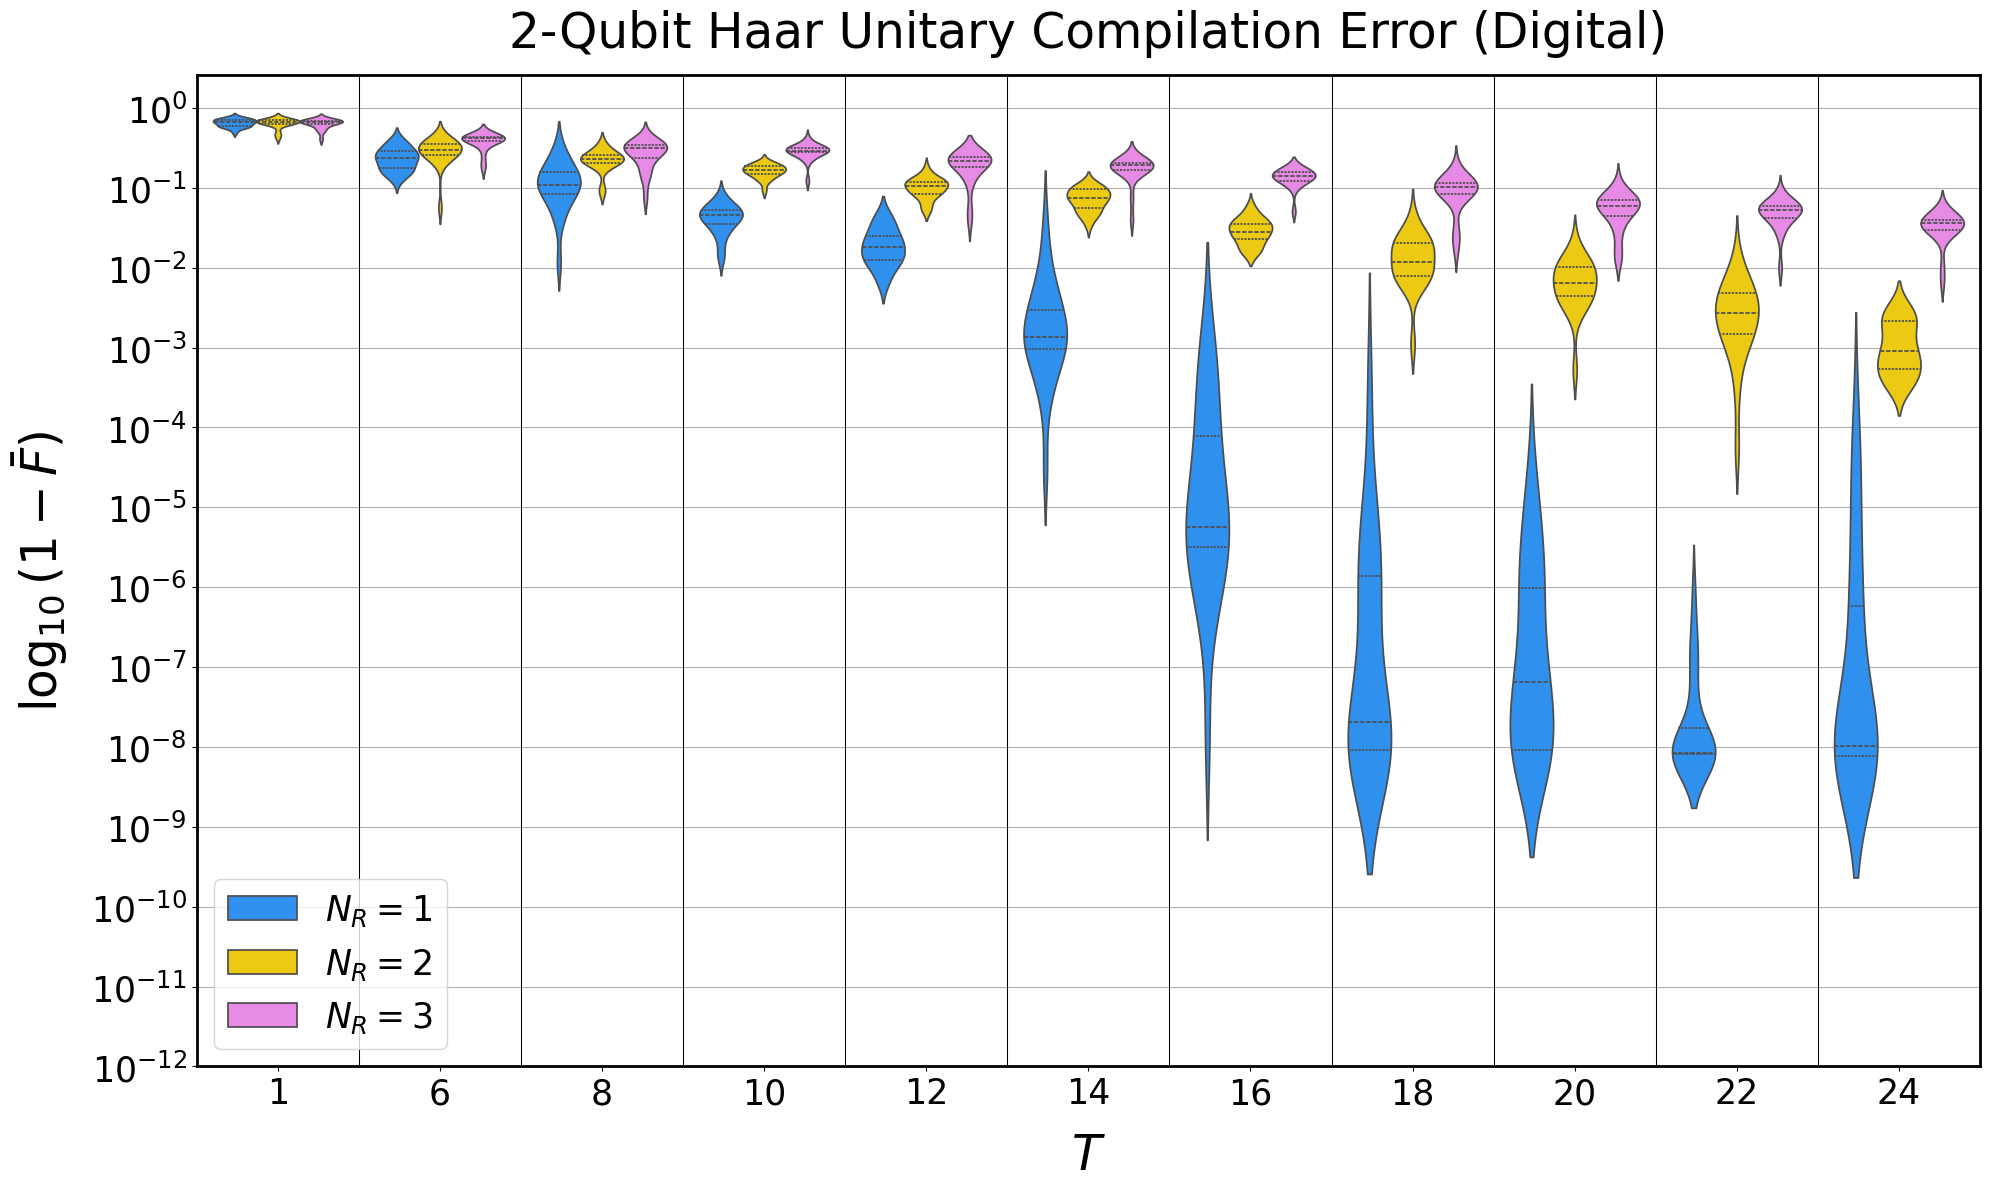

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
plt.close('all')  # Close previous figures to avoid conflicts
N_ctrls = [2]
resies = [1,2,3,4,5,6,7,8,9]
resies = [1,2,3]
for N_ctrl in N_ctrls:
    
    if N_ctrl == 2:
        trots = [1, 10, 11, 12, 13, 14, 16, 17,18, 20, 22, 24, 26, 28]
        resies = [1,2,3]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
        resies = [1,2,3]
    else:
        trots = np.arange(1, 50, 1)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and Reservoir Count
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'Reservoir Count'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results)
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")

# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8,10, 12,14, 16, 18,20,22,24,25,26,27,28]
        # trots = [1,2,3,4,5,6]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]
    # Ensure there are no NaNs in the 'Avg Error' column
    if data_df['Avg_infidelity'].isna().any():
        raise ValueError("NaN values detected in the 'Avg Error' column! Check the data preprocessing step.")
    # Check the entire DataFrame for NaNs or Infs before plotting
    if data_df.isna().any().any():
        print("NaN values detected in the DataFrame:")
        print(data_df.isna().sum())
        raise ValueError("NaN values found in the DataFrame!")
    if np.isinf(data_df.select_dtypes(include=[np.number])).any().any():
        print("Infinity values detected in the DataFrame:")
        print(data_df[np.isinf(data_df.select_dtypes(include=[np.number]))])
        raise ValueError("Infinity values found in the DataFrame!")
#    Check for NaNs or Infs in Avg_infidelity
    if data_df['Avg_infidelity'].isna().any():
        print("NaN values detected in 'Avg_infidelity':")
        print(data_df[data_df['Avg_infidelity'].isna()])
        raise ValueError("NaN values detected in the 'Avg_infidelity' column! Check the data preprocessing step.")

    # Check for infinity values in the 'Avg_infidelity' column
    if np.isinf(data_df['Avg_infidelity']).any():
        print("Infinity values detected in 'Avg_infidelity':")
        print(data_df[np.isinf(data_df['Avg_infidelity'])])
        raise ValueError("Infinity values detected in the 'Avg_infidelity' column!")

    # Check for negative or zero values in 'Avg_infidelity'
    if (data_df['Avg_infidelity'] <= 0).any():
        print("Negative or zero values found in 'Avg_infidelity':")
        print(data_df[data_df['Avg_infidelity'] <= 0])
        raise ValueError("Negative or zero values detected in 'Avg_infidelity' column, which are invalid for log scale!")

    # # Explode test results into separate rows to plot each error individually
    # test_results_df = data_df.explode('Error_Test_Results')

    # # Find the common Trotter steps across all reservoir counts
    # grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    # valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # # Filter the DataFrame to only include those Trotter steps
    # test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    # test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])
   

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    sns.violinplot(x='Trotter_Step', y='Avg Error', hue='Reservoir Count', data=data_df, 
                   ax=axs, palette=custom_palette,density_norm='width', inner='quartile', saturation=0.85)
    # sns.violinplot(x='Trotter_Step', y='Avg_infidelity', hue='Reservoir Count', data=data_df, 
    #                ax=axs, palette=custom_palette,log_scale=True, density_norm='width', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Set the global Y-limits
    # Set y-axis limits explicitly
    # axs.set_ylim(y_min, y_max)

    # Set Y-ticks and labels
    # y_ticks = axs.get_yticks()
    # print(f"Original y_ticks: {y_ticks}")

    # # Ensure 10^0 is included in the ticks
    # if 1 not in y_ticks:
    #     y_ticks = np.sort(np.append(y_ticks, 1))  # Add 10^0 and re-sort

    # print(f"y_ticks: {y_ticks}")
    # y_min =min(y_ticks)
    # y_max = max(y_ticks)
    # axs.set_yticks(y_ticks)
    # axs.set_yticklabels([f"$10^{{{int(np.log10(tick))}}}$" for tick in y_ticks])

    y_ticks = axs.get_yticks()
    # axs.set_ylim(global_min_y, global_max_y)
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    print(whole_y_ticks)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = data_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()

    


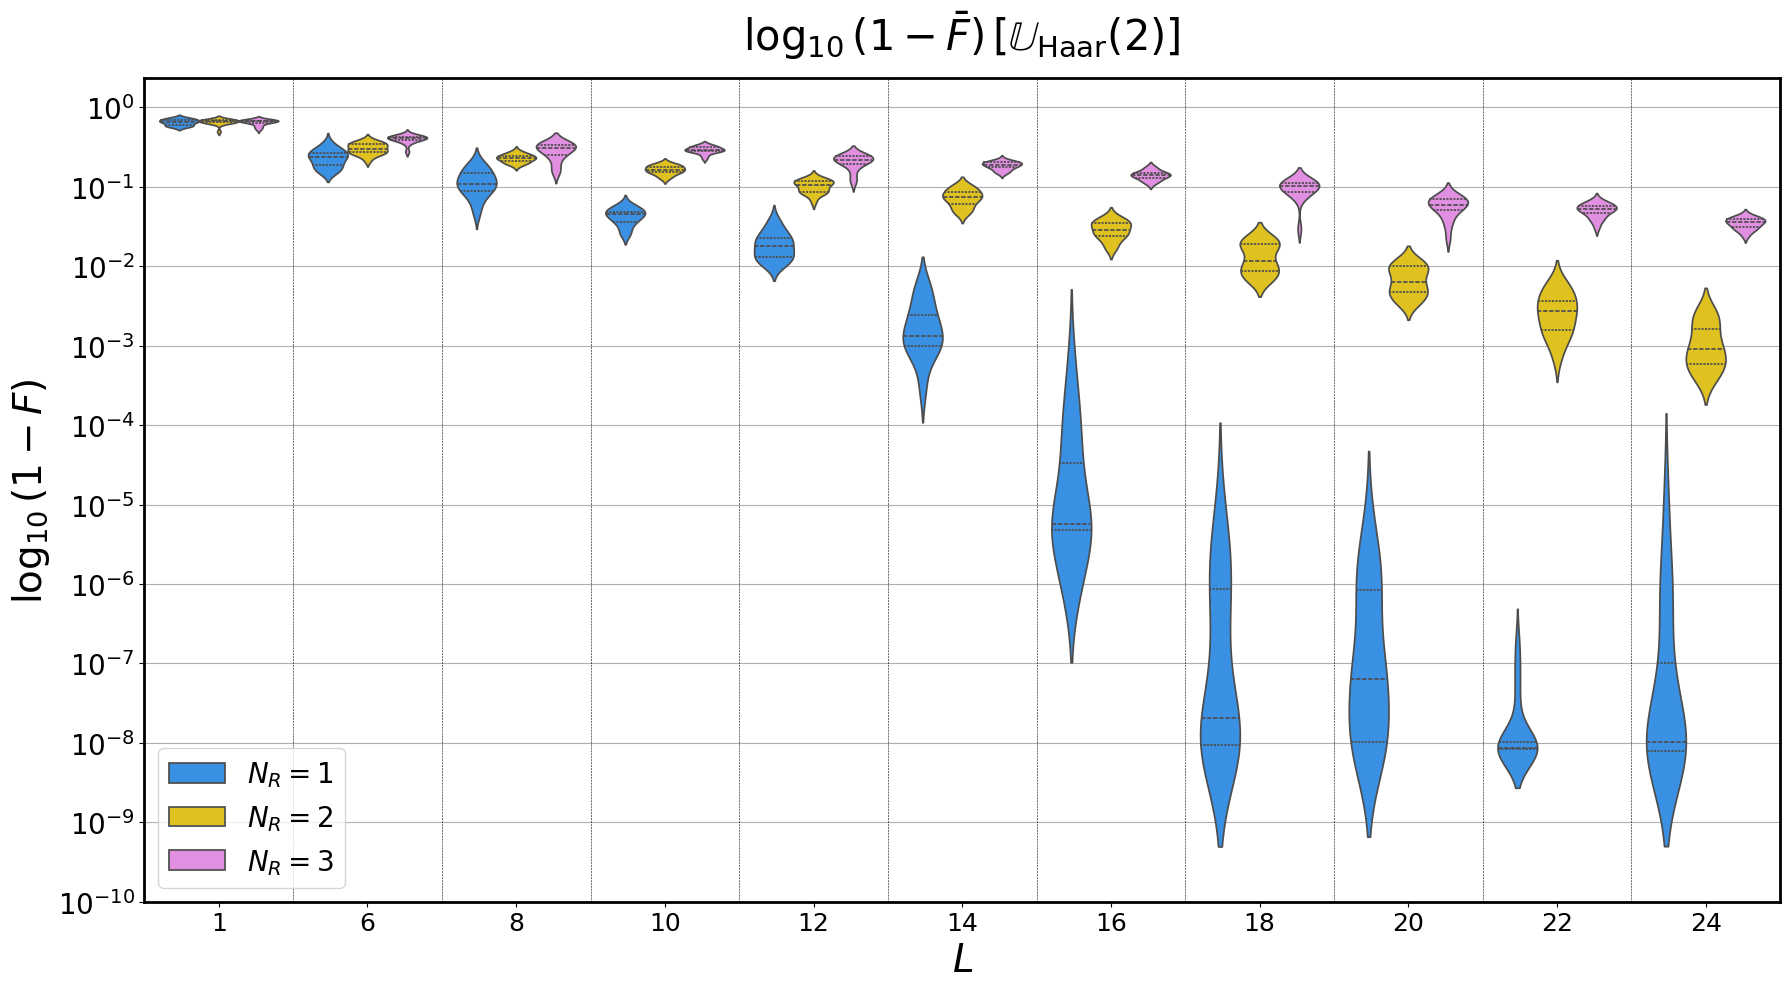

In [124]:
# Filter for Trotter_Step, Reservoir Count, and N_C
data_df = all_data_df[
    (all_data_df['N_C'] == N_ctrl) & 
    (all_data_df['Reservoir Count'].isin(resies)) &
    (all_data_df['Trotter_Step'].isin(trots))
]

# Calculate IQR for 'Avg Error'
avg_error_iqr_filtered_data = []
grouped_avg_error = data_df.groupby(['Trotter_Step', 'Reservoir Count'])
for (trotter_step, reservoir_count), group in grouped_avg_error:
    q1 = np.percentile(group['Avg Error'], 10)
    q3 = np.percentile(group['Avg Error'], 90)

    # Filter data within IQR for 'Avg Error'
    filtered_group = group[(group['Avg Error'] >= q1) & (group['Avg Error'] <= q3)]
    avg_error_iqr_filtered_data.append(filtered_group)

avg_error_iqr_filtered_data_df = pd.concat(avg_error_iqr_filtered_data)

# Explode 'Error_Test_Results' for individual values
test_results_df = data_df.explode('Error_Test_Results')

# Calculate IQR for 'Error_Test_Results'
error_test_results_iqr_filtered_data = []
grouped_error_test_results = test_results_df.groupby(['Trotter_Step', 'Reservoir Count'])
for (trotter_step, reservoir_count), group in grouped_error_test_results:
    q1 = np.percentile(group['Error_Test_Results'], 5)
    q3 = np.percentile(group['Error_Test_Results'], 95)

    # Filter data within IQR for 'Error_Test_Results'
    filtered_group = group[
        (group['Error_Test_Results'] >= q1) & (group['Error_Test_Results'] <= q3)
    ]
    error_test_results_iqr_filtered_data.append(filtered_group)

error_test_results_iqr_filtered_data_df = pd.concat(error_test_results_iqr_filtered_data)
fig, axs = plt.subplots(1, figsize=(18, 10))
for spine in axs.spines.values():
    spine.set_linewidth(2)

# Violin plot for IQR-filtered 'Avg Error'
sns.violinplot(
    x='Trotter_Step',
    y='Avg Error',
    hue='Reservoir Count',
    data=avg_error_iqr_filtered_data_df,
    ax=axs,
    palette=custom_palette,
    density_norm='width',
    inner='quartile'
)

axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$L$', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)

# Adjust Y-ticks
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

axs.tick_params(axis='y', labelsize=20)
axs.tick_params(axis='x', labelsize=18)

# Add vertical lines
unique_x_ticks = sorted(avg_error_iqr_filtered_data_df['Trotter_Step'].unique())
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.tight_layout()
plt.show()


[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.]


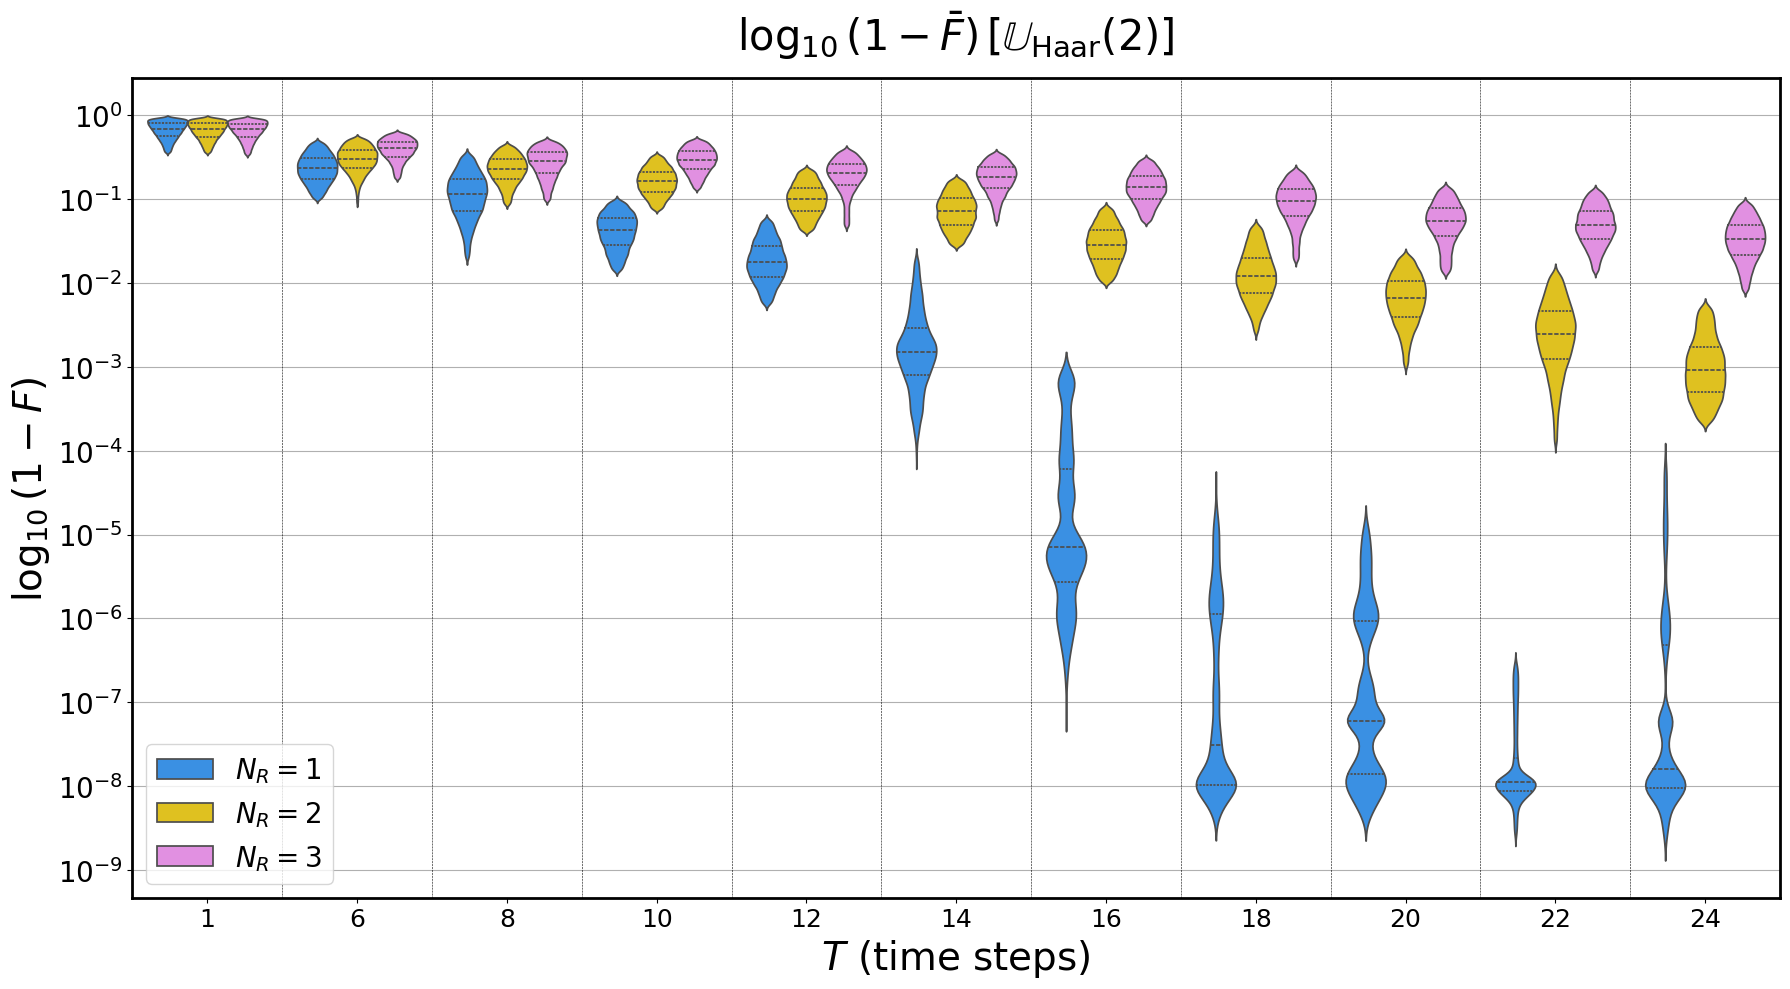

In [126]:
fig, axs = plt.subplots(1, figsize=(18, 10))
for spine in axs.spines.values():
    spine.set_linewidth(2)

# Violin plot for IQR-filtered 'Error_Test_Results'
sns.violinplot(
    x='Trotter_Step',
    y='Error_Test_Results',
    hue='Reservoir Count',
    data=error_test_results_iqr_filtered_data_df,
    ax=axs,
    palette=custom_palette,
    density_norm='width',
    inner='quartile',
    saturation=0.75,
    # bw_adjust=0.5,
    common_norm=True
    
)

axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$T$ (time steps)', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)

# Adjust Y-ticks
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
print(whole_y_ticks)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

axs.tick_params(axis='y', labelsize=20)
axs.tick_params(axis='x', labelsize=18)

# Add vertical lines
unique_x_ticks = sorted(error_test_results_iqr_filtered_data_df['Trotter_Step'].unique())
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.tight_layout()
plt.show()


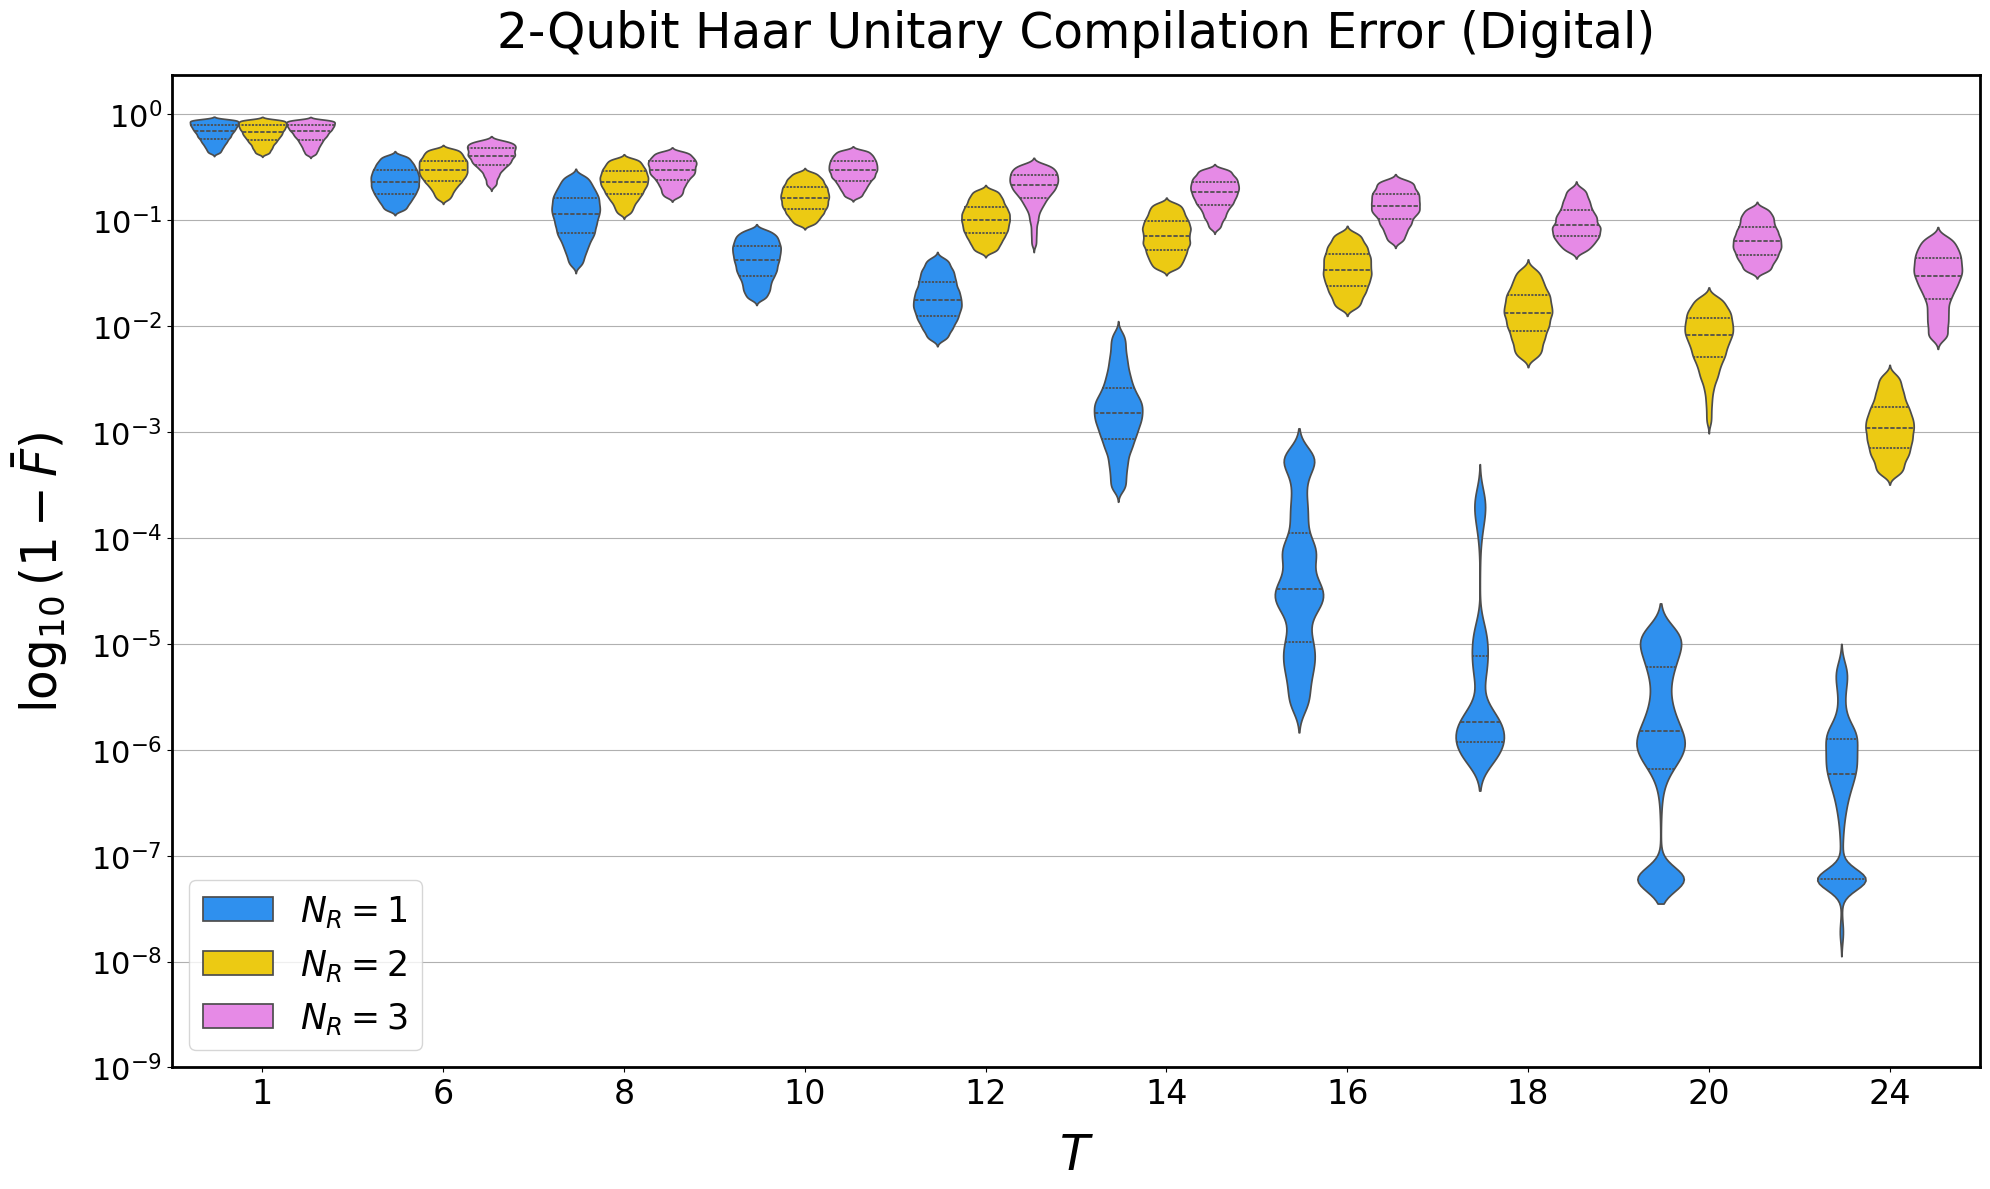

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = ['dodgerblue', 'gold', 'violet']
plt.close('all')  # Close previous figures to avoid conflicts

N_ctrls = [2]
resies = [1, 2, 3]

for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 25, 26, 27, 28]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) &
                          (all_data_df['Trotter_Step'].isin(trots)) &
                          (all_data_df['Reservoir Count'].isin(resies))]

    # Explode 'Error_Test_Results' to get individual values for grouping
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Calculate IQR for each group
    iqr_filtered_data = []
    grouped = test_results_df_error.groupby(['Trotter_Step', 'Reservoir Count'])
    for (trotter_step, reservoir_count), group in grouped:
        q1 = np.percentile(group['Error_Test_Results'], 10)
        q3 = np.percentile(group['Error_Test_Results'], 90)
        iqr = q3 - q1

        # Filter the data to include only points within the IQR
        filtered_group = group[
            (group['Error_Test_Results'] >= q1) & (group['Error_Test_Results'] <= q3)
        ]
        iqr_filtered_data.append(filtered_group)

    # Concatenate the filtered data
    iqr_filtered_data_df = pd.concat(iqr_filtered_data)

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels
    
    # Violin plot for Error_Test_Results within the IQR
    sns.violinplot(
        x='Trotter_Step',
        y='Error_Test_Results',
        hue='Reservoir Count',
        data=iqr_filtered_data_df,
        ax=axs,
        palette=custom_palette,
        density_norm='width',
        inner='quartile',
        saturation=0.85,
    )

    # Set titles and labels with padding
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    axs.tick_params(axis='y', labelsize=22)
    axs.tick_params(axis='x', labelsize=24)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Prevent clipping of y-axis ticks/labels
    plt.tight_layout()
    plt.show()


global_min_fidelity: 0.3219049264624945, global_max_fidelity: 0.9999979516237748


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_48606/1188344180.py:15: RuntimeWarning: invalid value encountered in power
  return normalized ** self.gamma  # Exaggerate higher values
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_48606/1188344180.py:15: RuntimeWarning: invalid value encountered in power
  return normalized ** self.gamma  # Exaggerate higher values


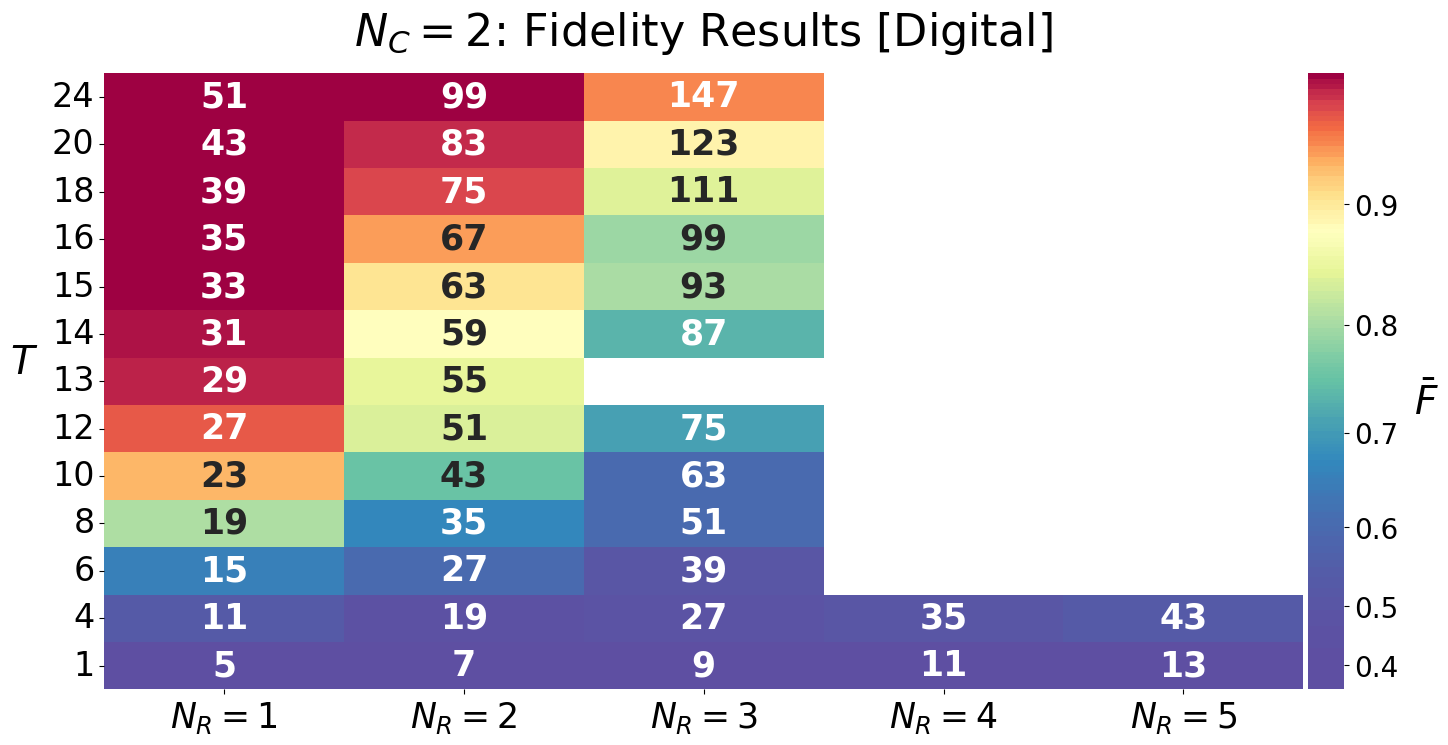

In [95]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm

from matplotlib.colors import Normalize
class ExaggeratedPowerNorm(Normalize):
    def __init__(self, gamma, vmin=None, vmax=None, clip=False):
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
        self.gamma = gamma

    def __call__(self, value, clip=None):
        vmin, vmax = self.vmin, self.vmax
        if vmin is None or vmax is None:
            raise ValueError("You must set both vmin and vmax for normalization")
        normalized = (value - vmin) / (vmax - vmin)  # Normalize to [0, 1]
        return normalized ** self.gamma  # Exaggerate higher values


width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

from matplotlib.colors import LinearSegmentedColormap


base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()

N_ctrls = [2]

# N_ctrls = [1,2]
# global_min_fidelity *= 1.25 
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 13,14, 15,16, 17,18,19,20,21,22, 24]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['Reservoir Count'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and Reservoir Count
    averaged_data = data_df.groupby(['Trotter_Step', 'Reservoir Count', 'N_params']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Std_Dev=('Avg_Fidelity', 'std')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Average_Fidelity")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 25}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    norm=ExaggeratedPowerNorm(gamma=1.5, vmin=global_min_fidelity, vmax=global_max_fidelity)  # Custom exaggeration norm

    # norm=PowerNorm(gamma=0.9, vmin=global_min_fidelity, vmax=global_max_fidelity)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
)

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'$N_{{C}} = {N_ctrl}$: Fidelity Results [Digital]', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=25, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_48606/4094013319.py:37: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Reservoir Count', data=test_results_df,


[-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


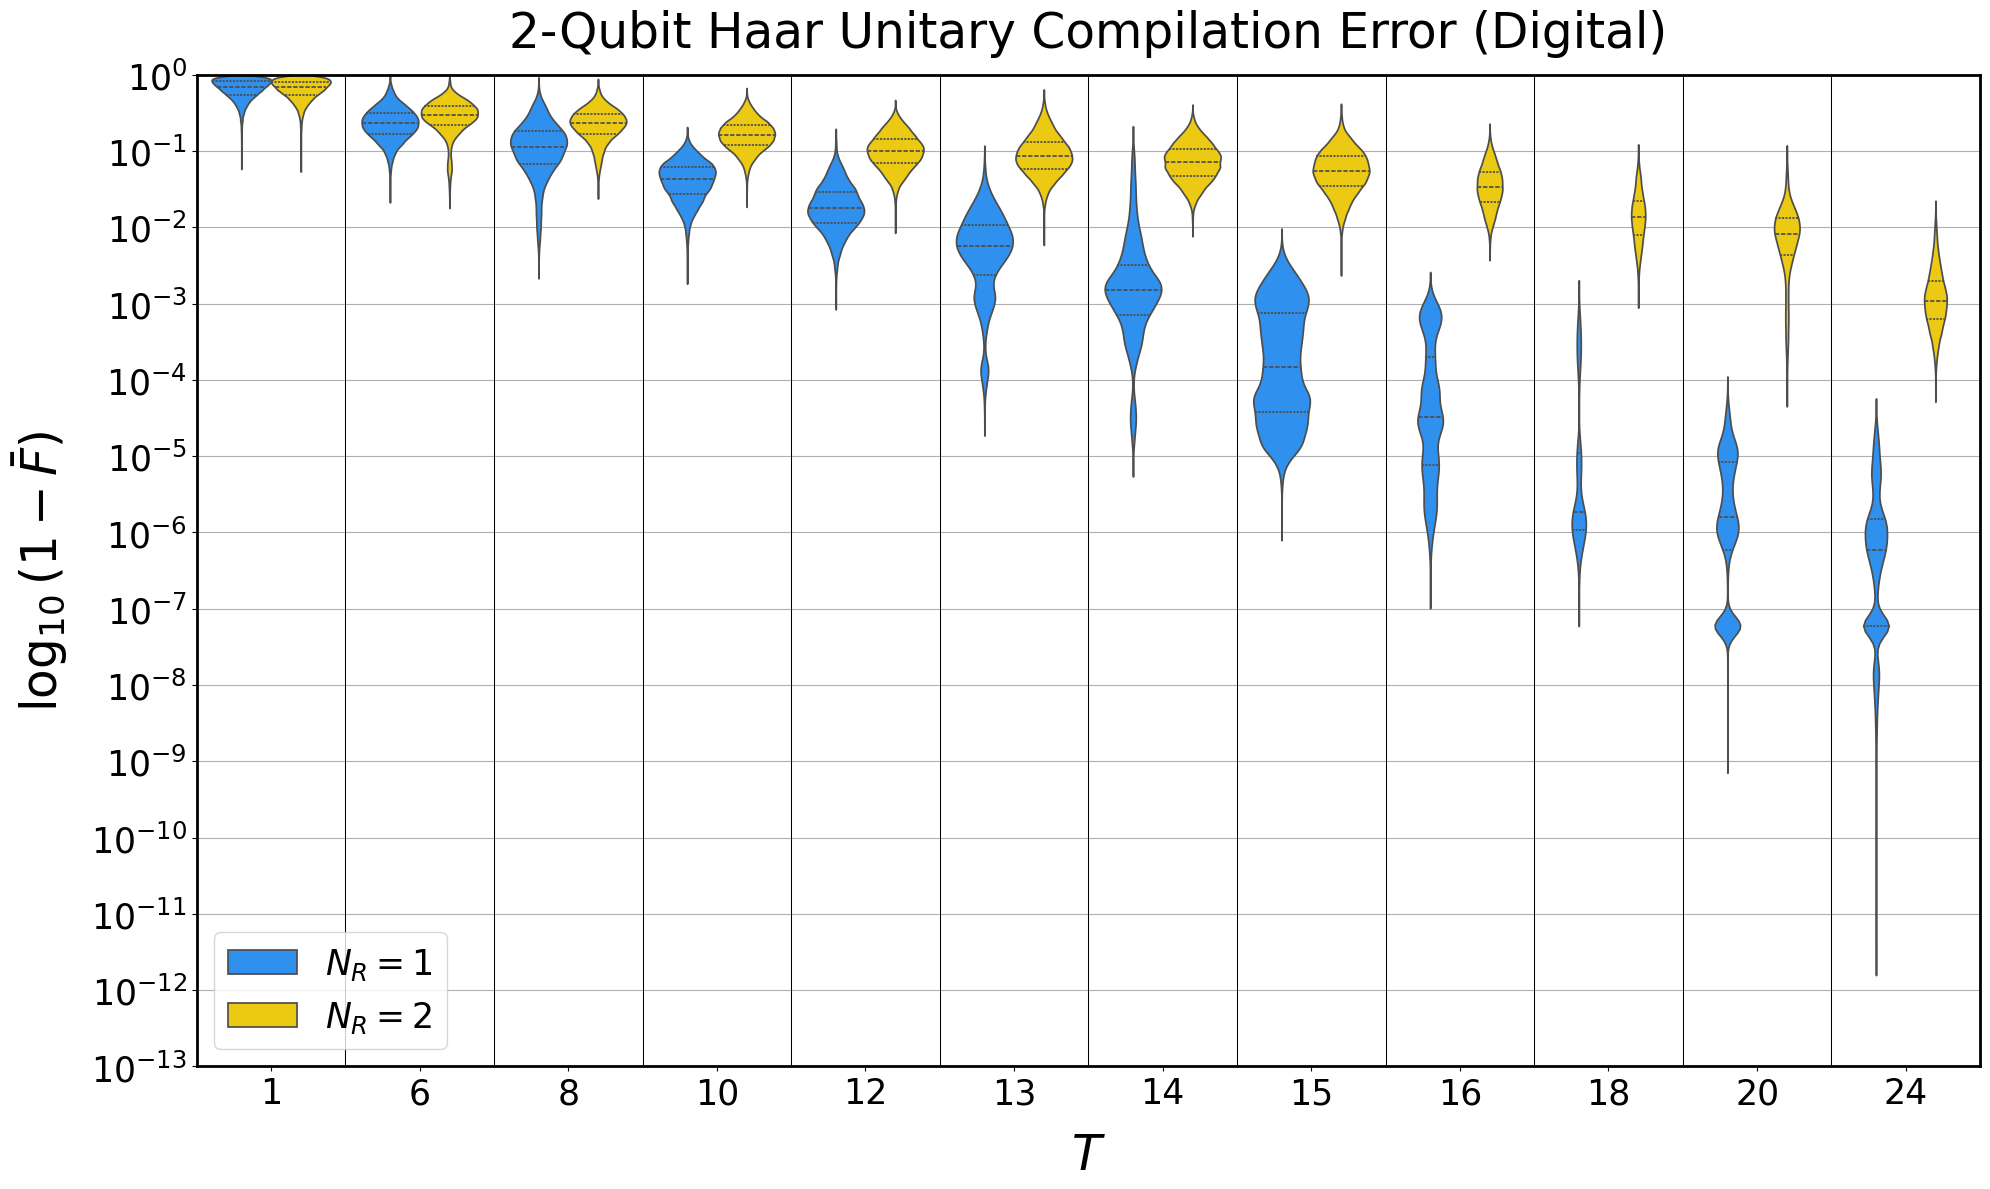

In [97]:
resies = [1,2]
N_ctrls = [2]
# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8,10, 12,13,14,15, 16,17, 18,19,20,22,24,25,26,27,28]
        # trots = [1,2,3,4,5,6]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error_Test_Results')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Reservoir Count', data=test_results_df, 
                   ax=axs,width=0.8, palette=custom_palette,log_scale=False,common_norm=True, density_norm='count', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
    print(whole_y_ticks)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()

   Trotter_Step  Error_Test_Results
0             1           -0.473016
0             1           -0.253508
0             1           -0.193849
0             1           -0.488837
0             1           -0.331586


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_48606/2810901248.py:22: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


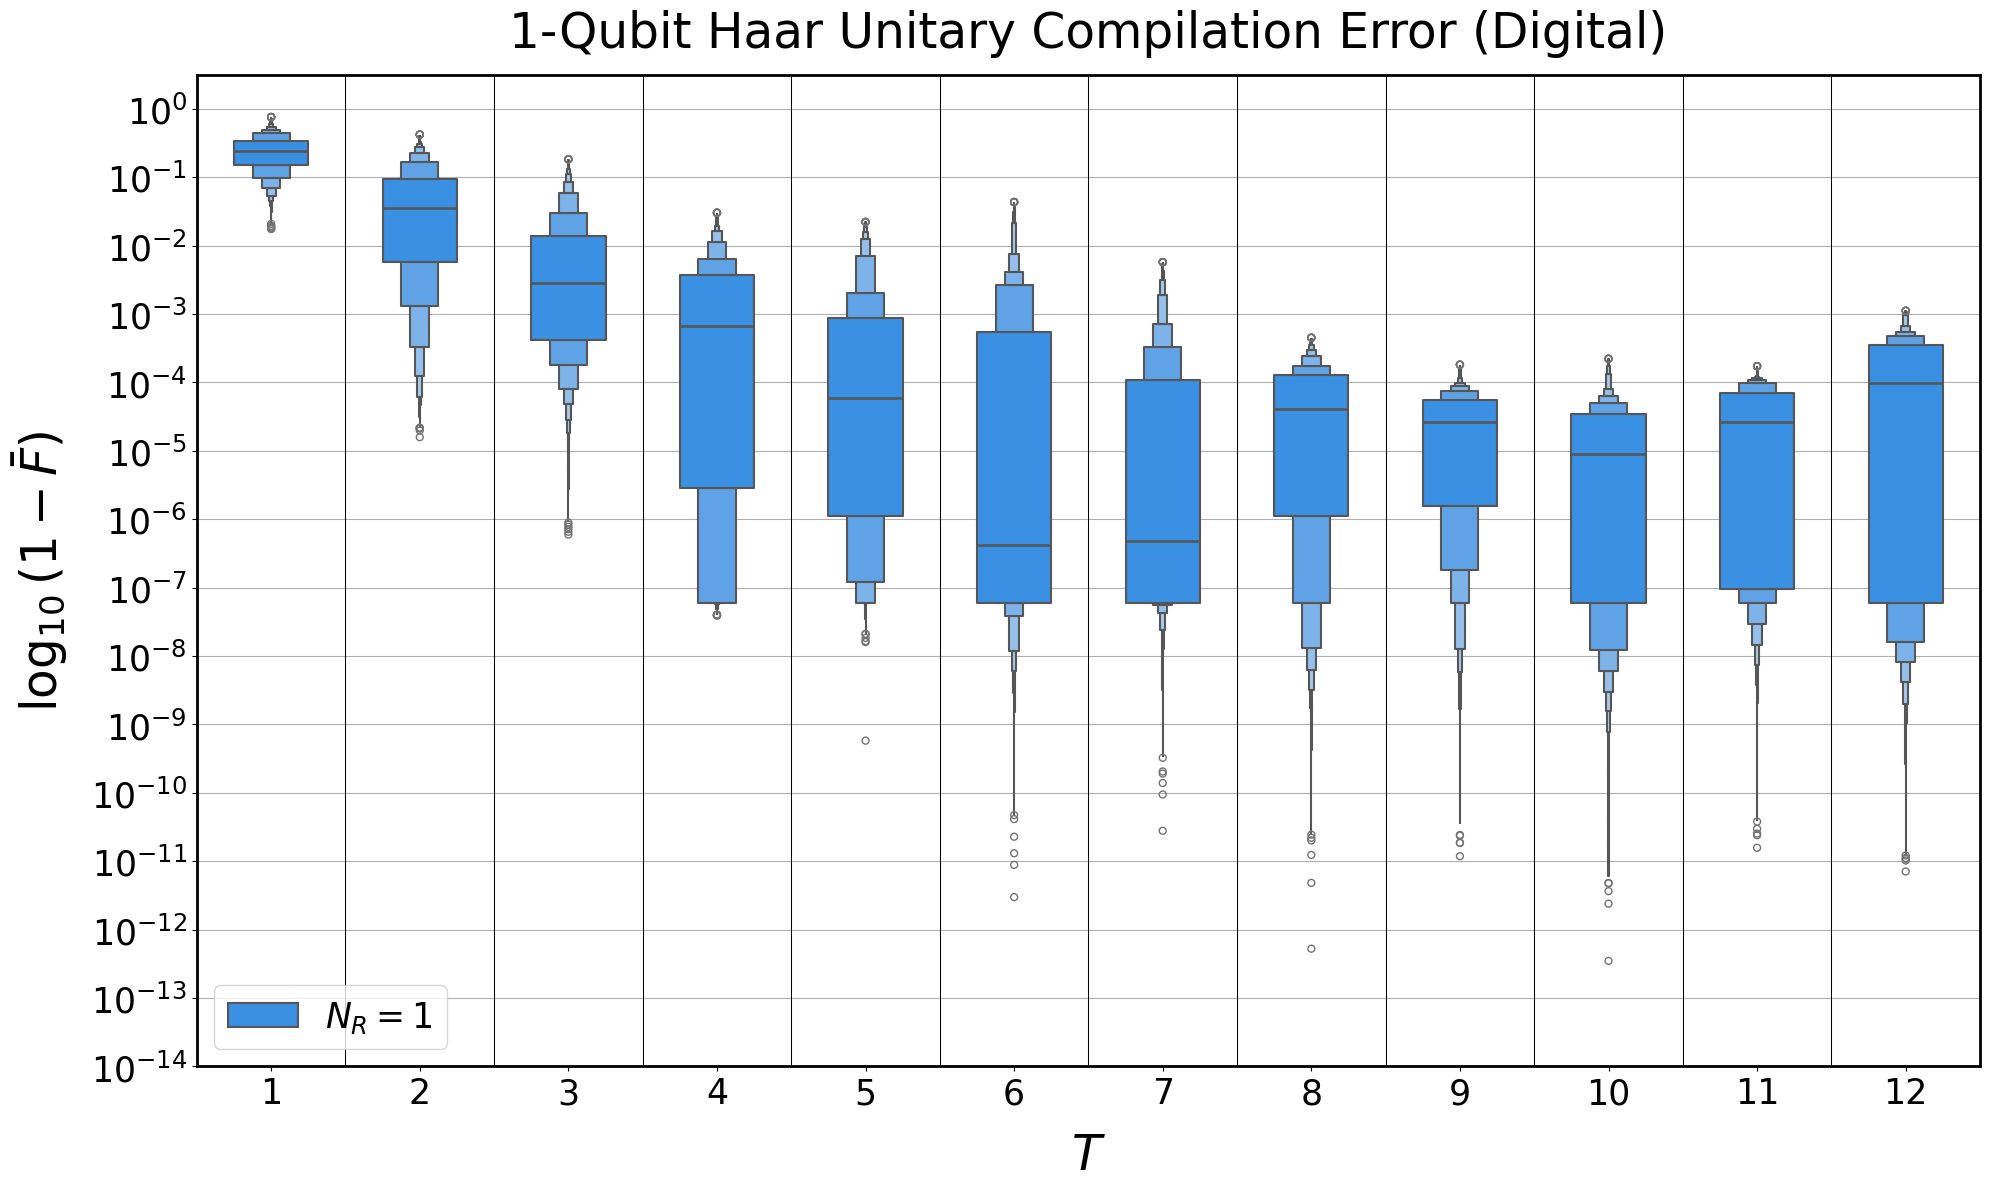

In [84]:
# Ensure that 'Error_Test_Results' is exploded properly
if isinstance(test_results_df['Error_Test_Results'].iloc[0], list):
    test_results_df = test_results_df.explode('Error_Test_Results', ignore_index=True)

# Ensure 'Error_Test_Results' is numeric
test_results_df['Error_Test_Results'] = pd.to_numeric(test_results_df['Error_Test_Results'], errors='coerce')

# Drop rows with NaN values in 'Error_Test_Results'
test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

# Recheck the DataFrame
print(test_results_df[['Trotter_Step', 'Error_Test_Results']].head())

# Proceed with the boxenplot
fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Boxenplot for Error_Test_Results (log10(1 - Test Results))
sns.boxenplot(
    x='Trotter_Step',
    y='Error_Test_Results',
    hue='Reservoir Count',
    data=test_results_df,
    ax=axs,
    palette=custom_palette,
    k_depth='tukey',
    linewidth=1.5,
    width_method="exponential",
    width=.5
)

# Set titles and labels with padding
axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)
axs.tick_params(axis='y', labelsize=25)
axs.tick_params(axis='x', labelsize=25)

# Add vertical lines to separate groups
unique_trotter_steps = test_results_df['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)
# Set the global Y-limits
# axs.set_ylim(global_min_y, global_max_y)

# Prevent clipping of y-axis ticks/labels
plt.tight_layout()
plt.show()


TypeError: unhashable type: 'list'

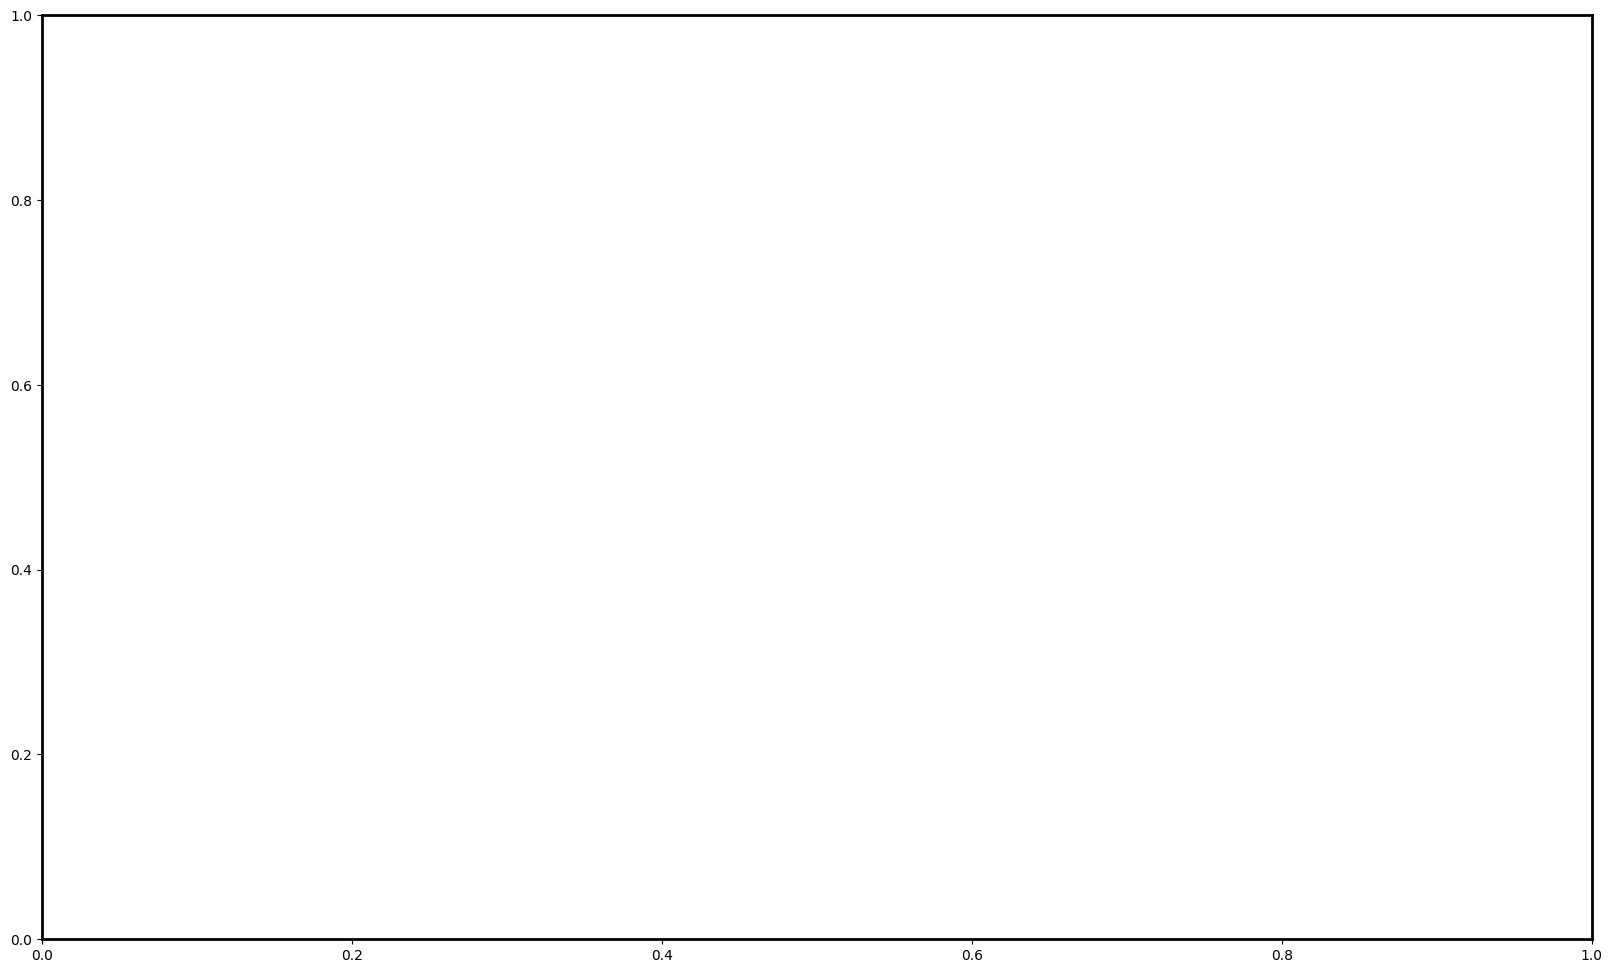

In [71]:
# Plot for each control qubit
resies=[1]
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Avg Error')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]
    test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])
    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Boxenplot for Error_Test_Results (log10(1 - Test Results))
    sns.boxenplot(
        x='Trotter_Step',
        y='Error_Test_Results',
        hue='Reservoir Count',
        data=test_results_df,
        ax=axs,
        palette=custom_palette,
        k_depth='tukey',
        linewidth=1.5,
        width_method="exponential",
        width=.5
    )

    # Set titles and labels with padding
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding

    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    plt.tight_layout()
    plt.show()



/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/12502232.py:32: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


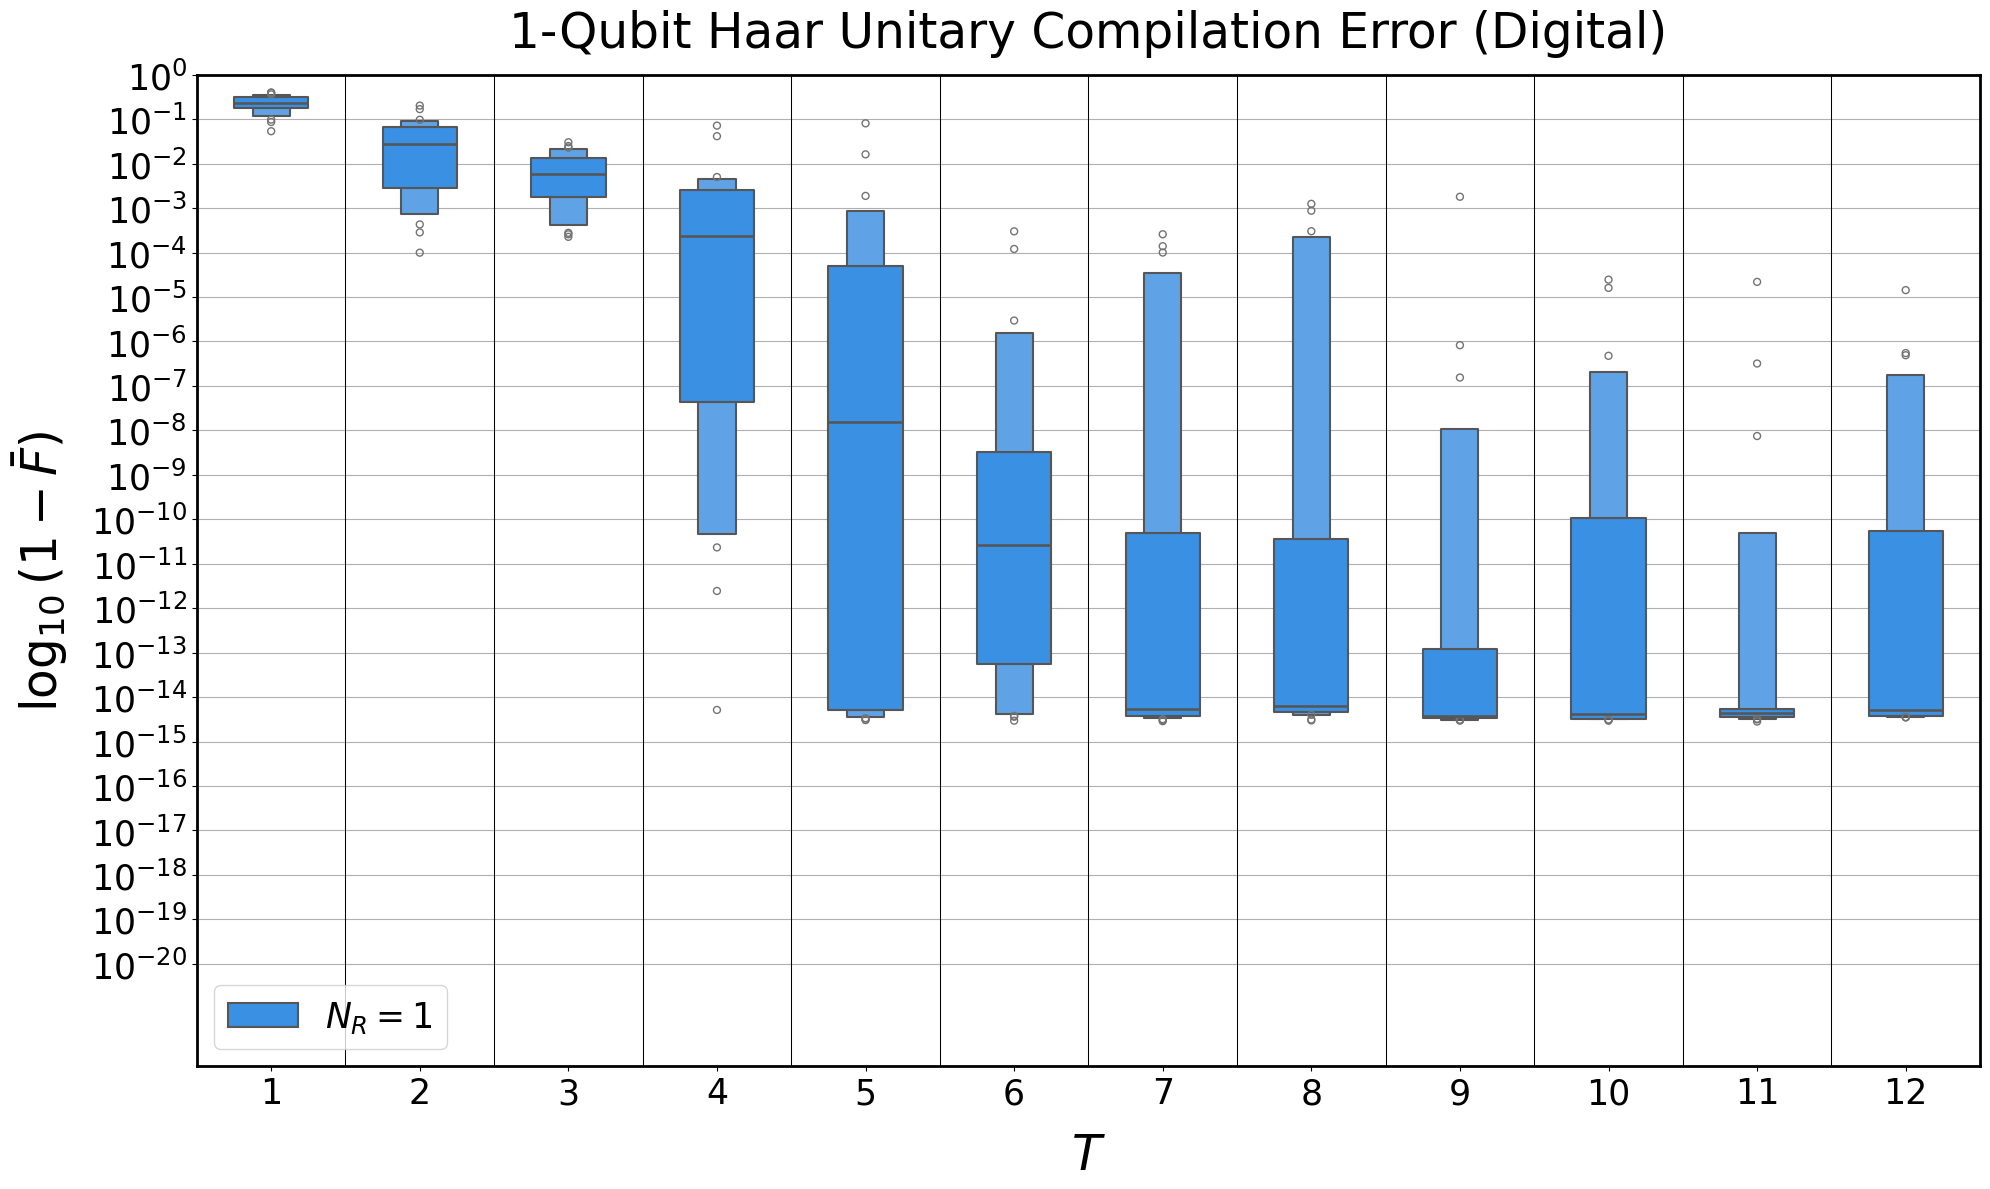

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/12502232.py:32: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


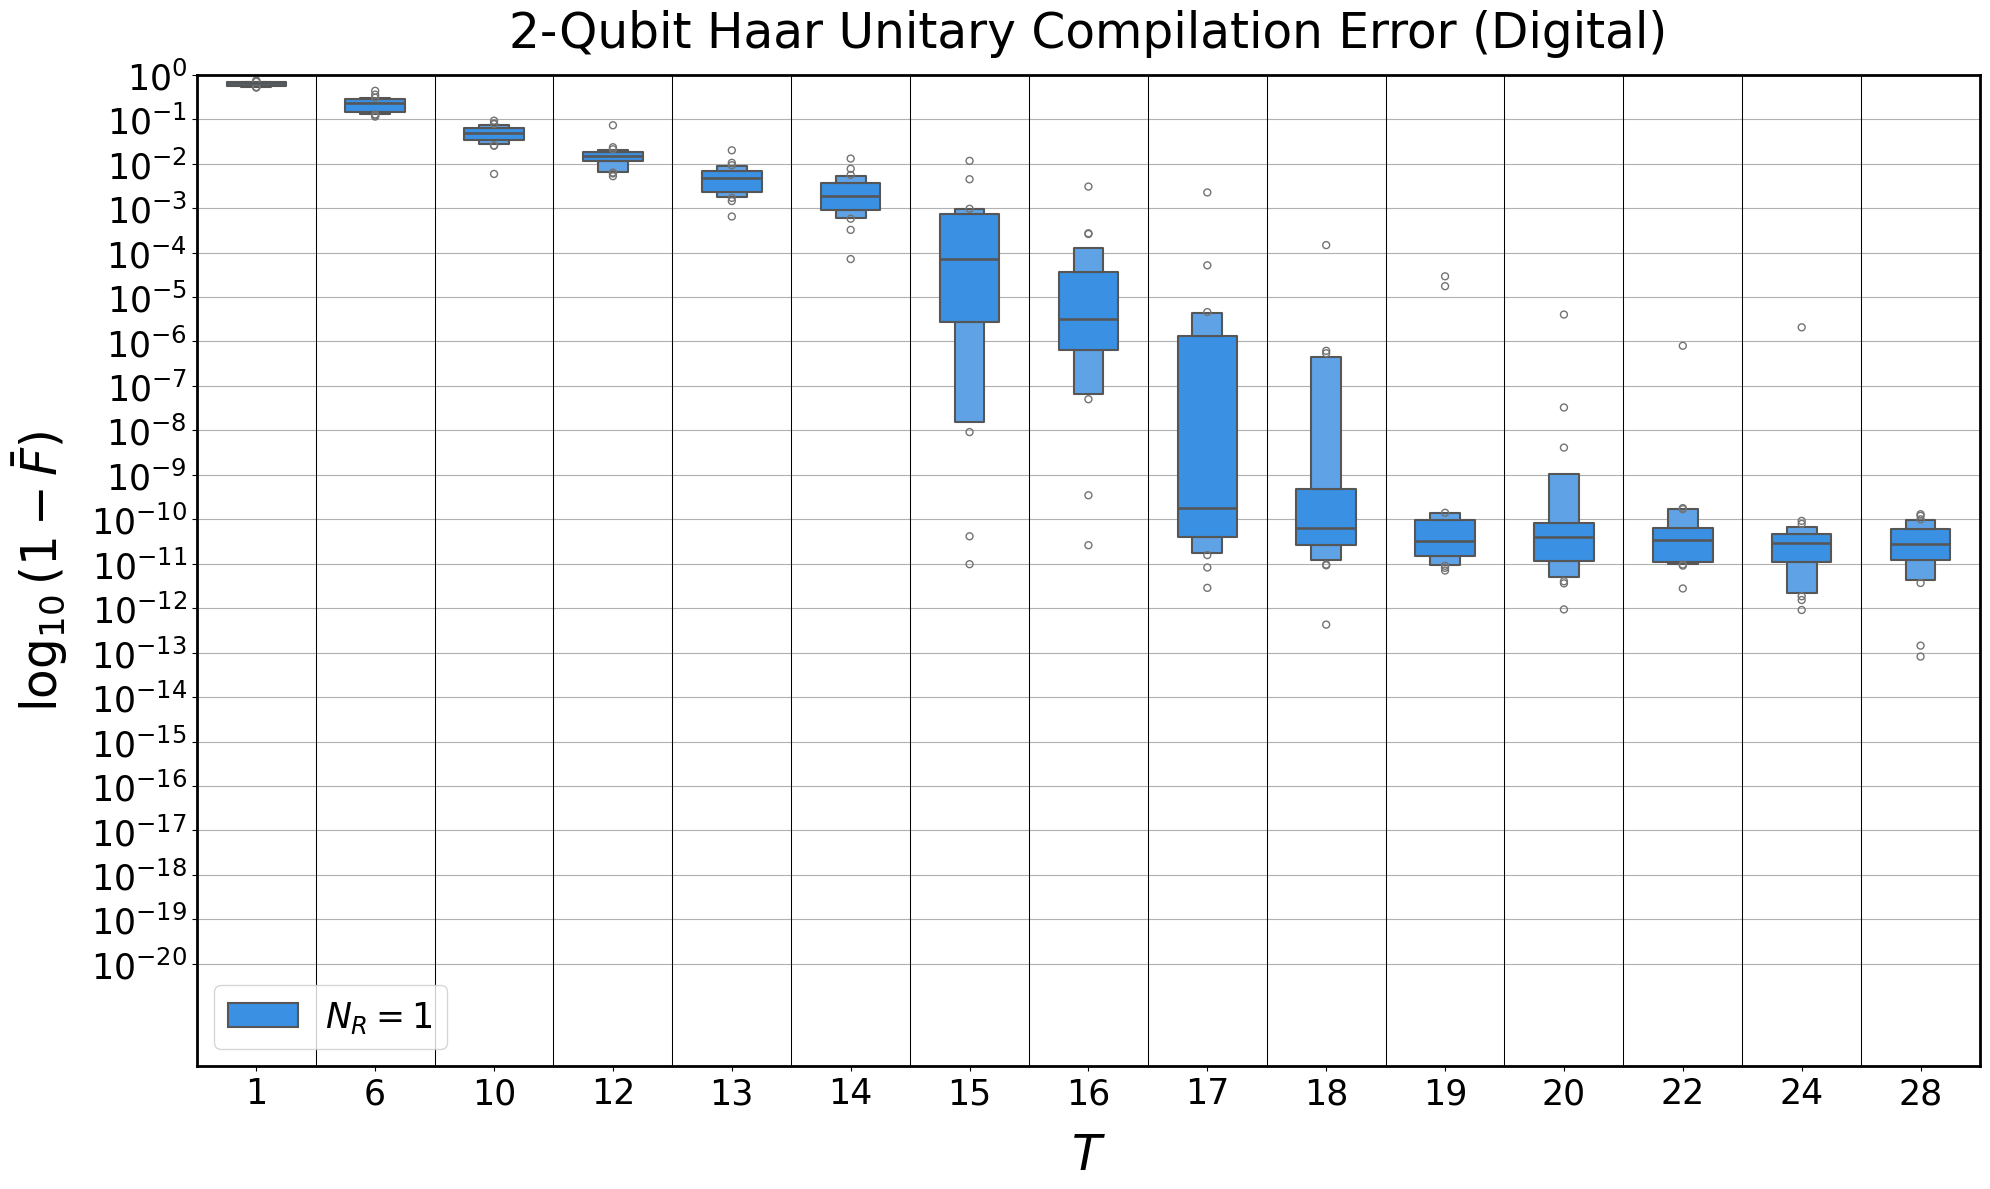

In [ ]:
# Plot for each control qubit
resies=[1]
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Avg Error')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Boxenplot for Error_Test_Results (log10(1 - Test Results))
    sns.boxenplot(
        x='Trotter_Step',
        y='Avg Error',
        hue='Reservoir Count',
        data=test_results_df,
        ax=axs,
        palette=custom_palette,
        k_depth='trustworthy',
        linewidth=1.5,
        width_method="linear",
        width=.5
    )

    # Set titles and labels with padding
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding

    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    plt.tight_layout()
    plt.show()



/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/3826992157.py:32: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


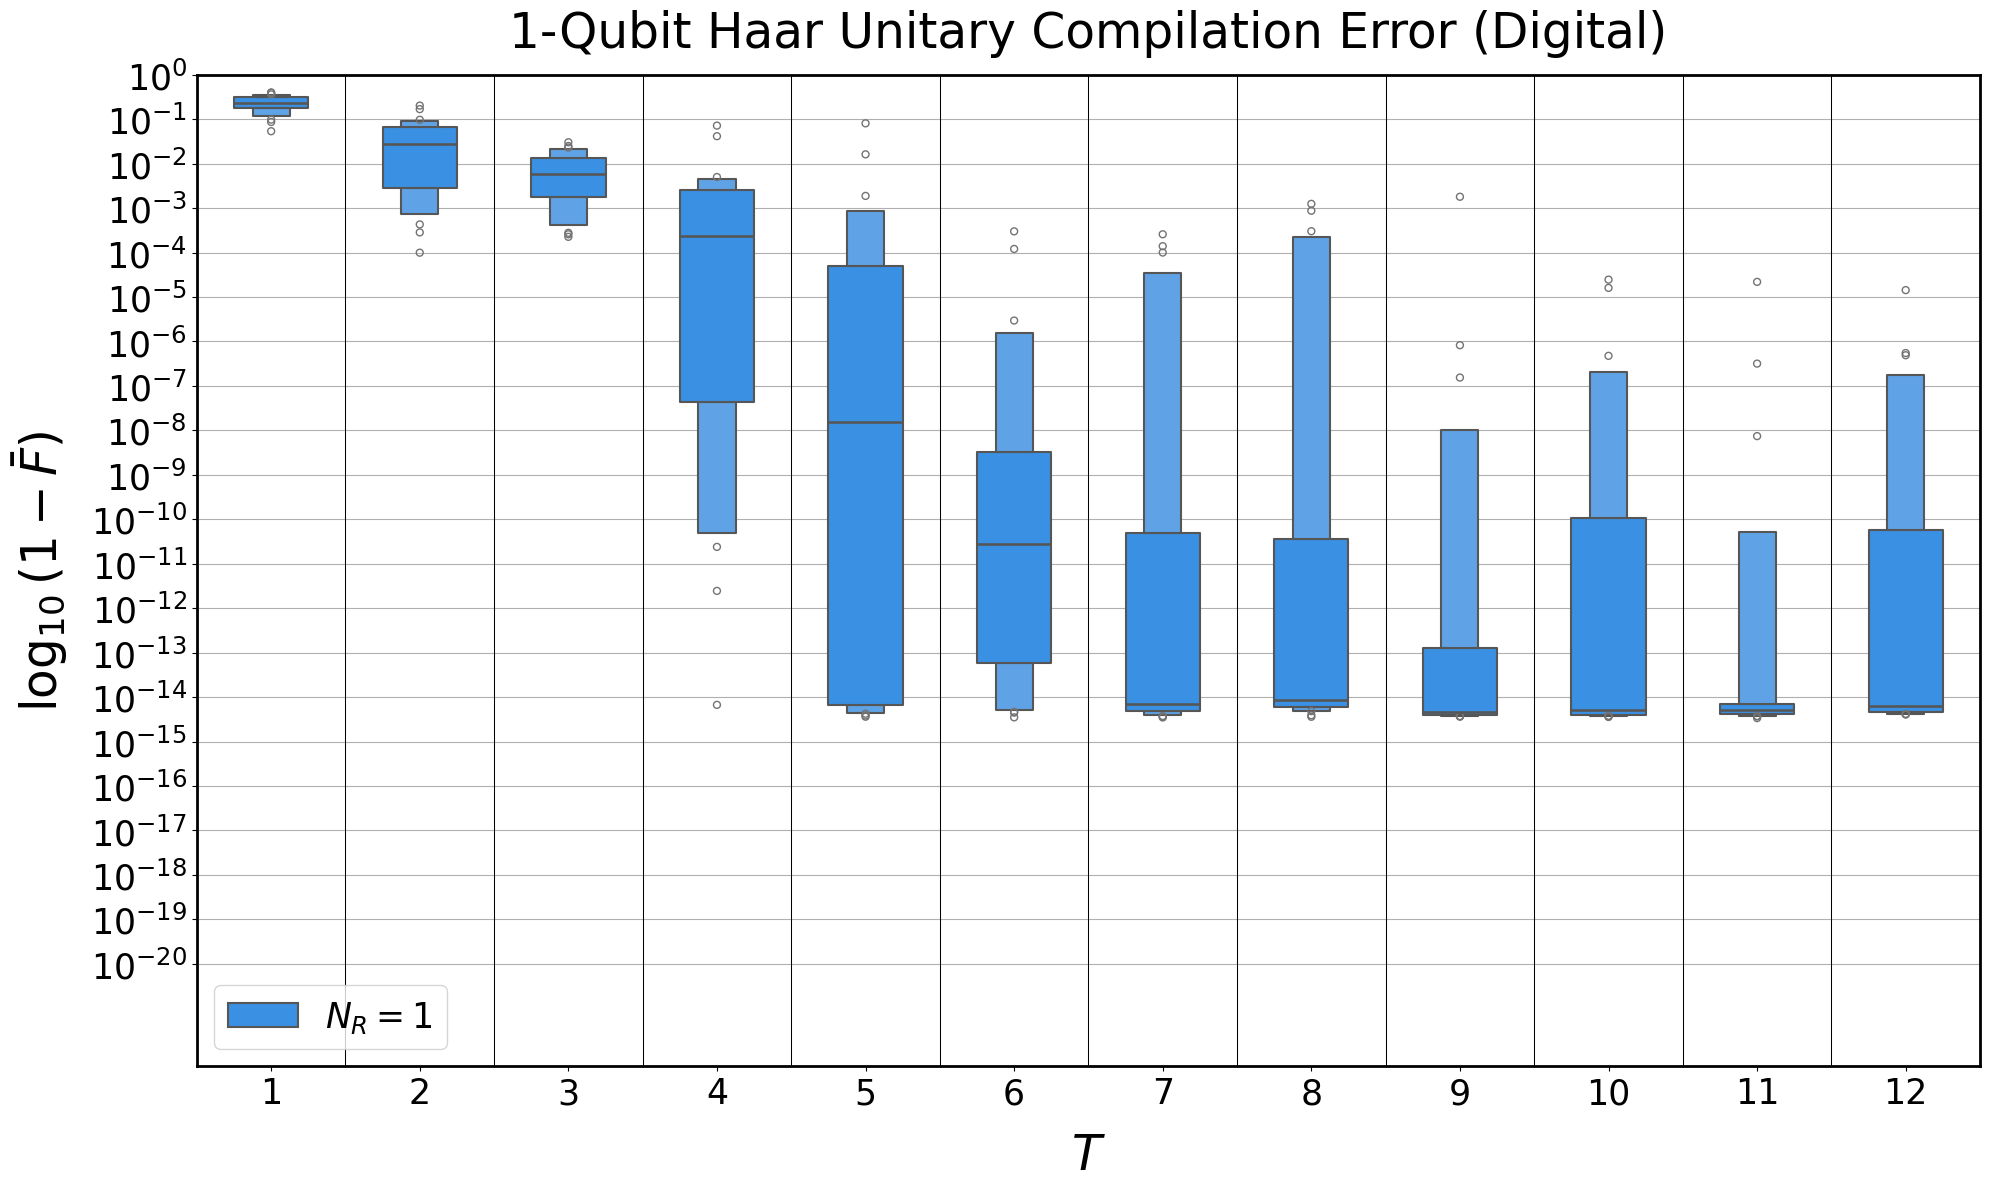

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/3826992157.py:32: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


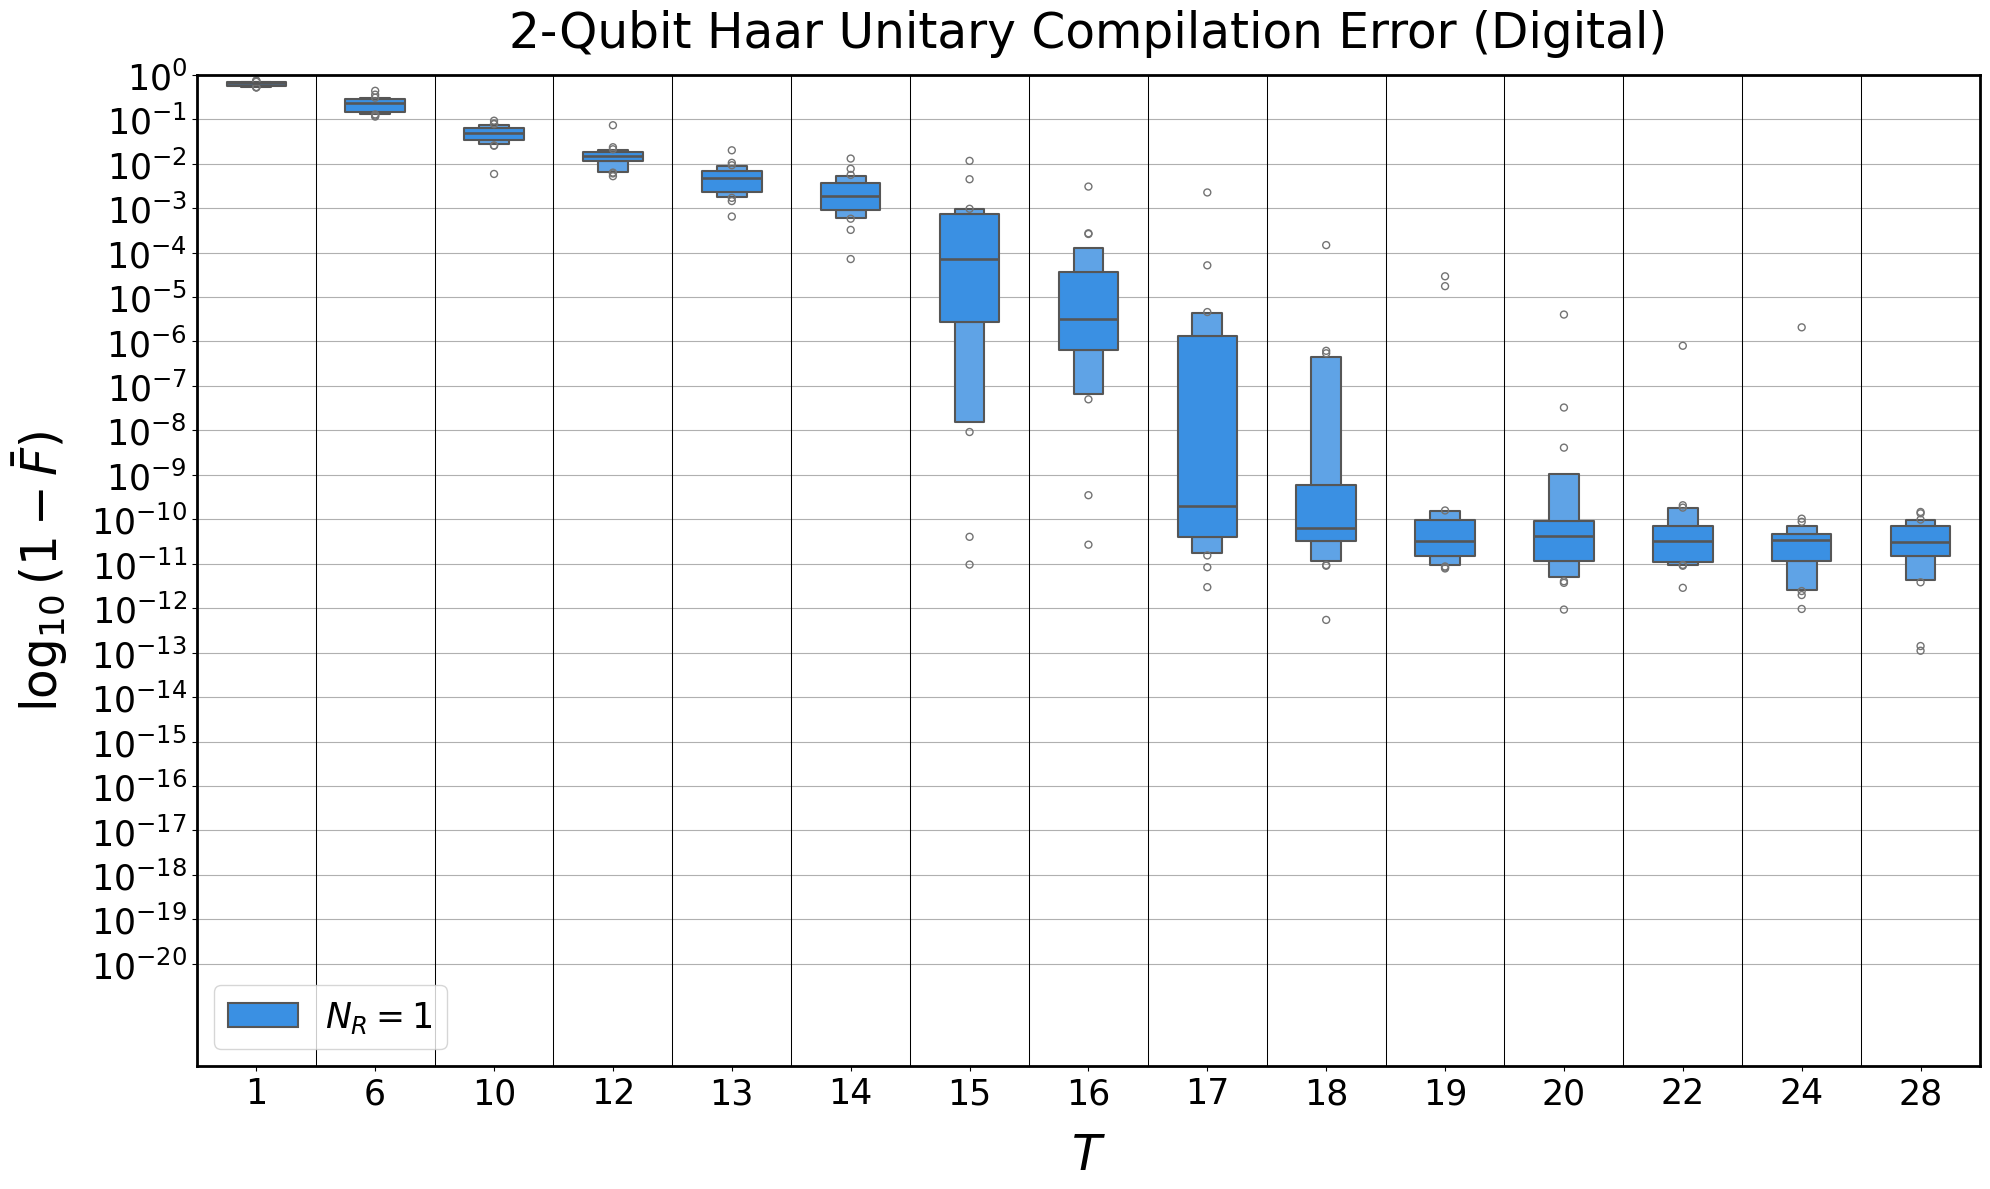

In [371]:
# Plot for each control qubit
resies=[1]
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Avg Error')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Boxenplot for Error_Test_Results (log10(1 - Test Results))
    sns.boxenplot(
        x='Trotter_Step',
        y='Avg Error',
        hue='Reservoir Count',
        data=test_results_df,
        ax=axs,
        palette=custom_palette,
        k_depth='trustworthy',
        linewidth=1.5,
        width_method="linear",
        width=.5
    )

    # Set titles and labels with padding
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding

    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    plt.tight_layout()
    plt.show()


Filtering data for N_ctrl=2 and N_R=1...
Calculating median and IQR...


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/3432027911.py:280: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


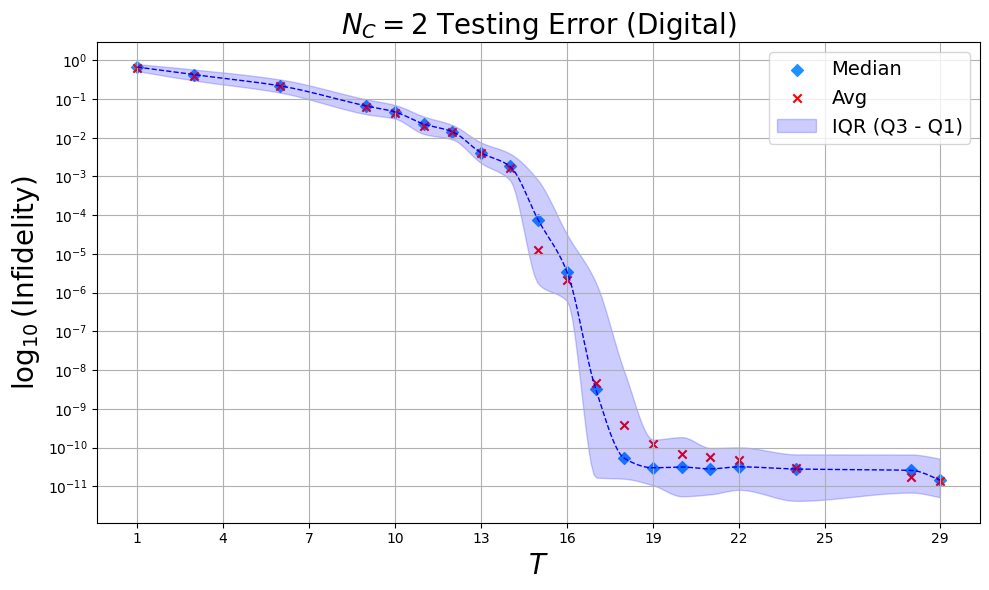

Filtering data for N_ctrl=2 and N_R=2...
Calculating median and IQR...


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/3432027911.py:391: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


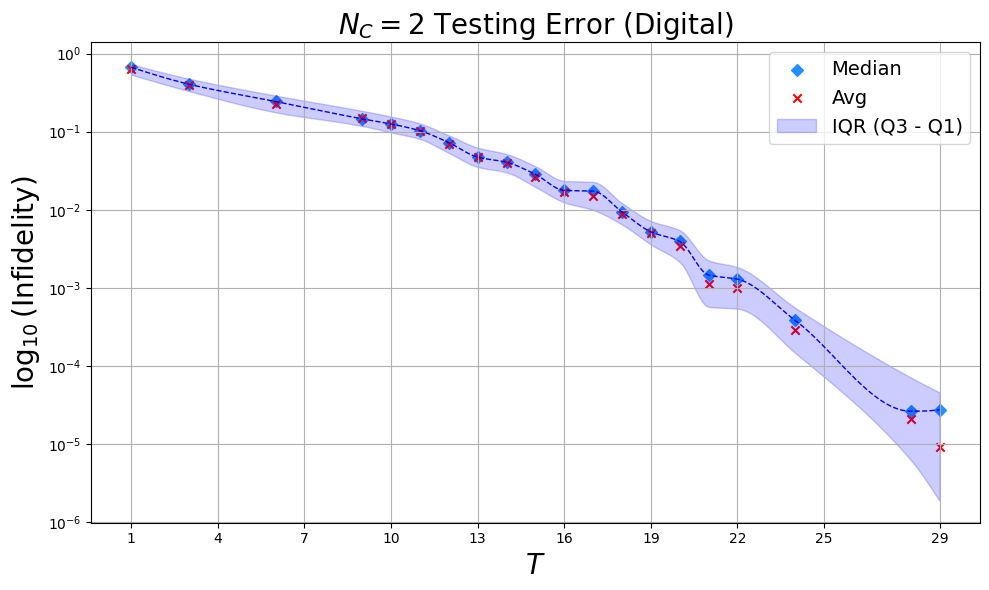

In [390]:
def plot_error_with_iqr_averaged(data_df, N_ctrl, N_R, xlabel, ylabel, title):
    """
    Plot error statistics using the median and IQR for averaged fidelity per gate.
    """

    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Explode the list of infidelities into individual rows
    print("Exploding averaged infidelities into individual rows...")
    exploded_df = filtered_df.explode('Avg_infidelity').reset_index()

    # Ensure that the exploded column contains only numeric data
    exploded_df['Avg_infidelity'] = pd.to_numeric(exploded_df['Avg_infidelity'], errors='coerce')

    # Calculate median and IQR for each Trotter step
    print("Calculating median and IQR...")
    stats = exploded_df.groupby('Trotter_Step')['Avg_infidelity'].agg(
        median=np.median,
        q1=lambda x: np.percentile(x, 25),  # 25th percentile
        q3=lambda x: np.percentile(x, 75)   # 75th percentile
    ).reset_index()

    # Compute the bounds
    stats['lower_bound'] = stats['q1']  # Lower bound = Q1 (25th percentile)
    stats['upper_bound'] = stats['q3']  # Upper bound = Q3 (75th percentile)

    # Print the statistics
    print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    for _, row in stats.iterrows():
        print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, Q1: {row['lower_bound']}, Q3: {row['upper_bound']}")

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot the median line
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the lower bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['lower_bound'], 
        label='Lower Bound (Q1)', 
        linestyle='--', 
        color='red'
    )

    # Plot the upper bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['upper_bound'], 
        label='Upper Bound (Q3)', 
        linestyle='--', 
        color='red'
    )

    # Plot the shaded region (IQR)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['lower_bound'],
        stats['upper_bound'],
        color='dodgerblue',
        alpha=0.2,
        label='IQR (Q3 - Q1)'
    )

    # Customize the plot
    
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()

def compute_error_statistics(data_df, metric):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')[metric]  
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna() 
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 30)  # 25th percentile
            q3 = np.percentile(exploded_values, 70)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

def weighted_moving_average(values, window=3):
    """
    Compute a weighted moving average to smooth data.
    
    Args:
        values (array-like): Array of values to smooth.
        window (int): Size of the moving window.
    
    Returns:
        np.array: Smoothed values.
    """
    weights = np.arange(1, window + 1)  # Linear weights
    smoothed = np.convolve(values, weights / weights.sum(), mode='same')
    return smoothed

def plot_error_with_metric(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric='Total_Avg_Infidelity', std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the specified metrics.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', midpoint_metric, and std_metric.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
        lambda x: np.concatenate(x) if isinstance(x, list) else x
    )

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    # stats = (
    #     filtered_df.groupby('Trotter_Step', group_keys=False)
    #     .apply(lambda group: pd.Series({
    #         'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
    #         'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
    #         'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 75)   # Q3 from std_metric
    #     }))
    #     .reset_index()
    # )
    stats_list = []

    # Group by Trotter_Step
    for trotter_step, group in filtered_df.groupby('Trotter_Step'):
        # print(f"Processing Trotter Step: {trotter_step}")
        # print(f"Midpoint Metric Value: {group[midpoint_metric].iloc[0]}")

        # Extract the single value for the median
        median_value = group[midpoint_metric].iloc[0]  # Single value per group

        # Flatten the std_metric column for this group
        flattened_std_metric = np.concatenate(group[std_metric].values)
        # print(f"Flattened Std Metric: {flattened_std_metric}")

        # Calculate lower and upper bounds
        lower_bound = np.percentile(flattened_std_metric, 10)
        upper_bound = np.percentile(flattened_std_metric, 80)
        lower_bound2 = median_value-np.std(flattened_std_metric)/2
        upper_bound2 = median_value+np.std(flattened_std_metric, ddof=1)/2


        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"Lower Bound: {lower_bound2}, Upper Bound: {upper_bound2}\n")
        # Append the results as a dictionary
        stats_list.append({
            'Trotter_Step': trotter_step,
            'median': median_value,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })

    # Convert the list of dictionaries into a DataFrame
    stats = pd.DataFrame(stats_list)

    # Print statistics for verification
    print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    for _, row in stats.iterrows():
        print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']:.1e}, Q1: {row['lower_bound']:.1e}, Q3: {row['upper_bound']:.1e}")

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot the median line
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the lower bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['lower_bound'], 
        label='Lower Bound (Q1)', 
        linestyle='--', 
        color='red'
    )

    # Plot the upper bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['upper_bound'], 
        label='Upper Bound (Q3)', 
        linestyle='--', 
        color='red'
    )

    # Plot the shaded region (IQR)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['lower_bound'],
        stats['upper_bound'],
        color='dodgerblue',
        alpha=0.2,
        label='IQR (Q3 - Q1)'
    )

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()

from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
def plot_error_with_smoothed_bands(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        # For list-based metrics, flatten using np.concatenate
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # For scalar metrics, no flattening is needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            # 'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
             'median': np.median(np.concatenate(group[std_metric].values)), 
              
            'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
            'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 75),   # Q3 from std_metric
            'avg': np.mean(np.concatenate(group[std_metric].values)),   # Q3 from std_metric
            'std': np.std(np.concatenate(group[std_metric].values))   # Q3 from std_metric
        }))
        .reset_index()
    )
    
    # Print statistics for verification
    # print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']} | Median: {row['median']:.1e} | Mean: {row['avg']:.1e} | Q3-Q1: {abs(row['upper_bound']) - abs(row['lower_bound']):.2e} ")

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])
    pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Generate fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    # Evaluate the PCHIP interpolators
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)


    # # Evaluate the splines
    # median_smooth = spline_median(x_fine)
    # lower_smooth = spline_lower(x_fine)
    # upper_smooth = spline_upper(x_fine)

    # Plot the splines
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth,linestyle='--',lw=1, color='blue')
    plt.scatter(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='D', 
        color='dodgerblue'
    )
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    # plt.plot(x_fine, upper_smooth, label='Smoothed Upper Bound (Q3)', linestyle='--', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2,label='IQR (Q3 - Q1)')
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize the plot
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title(f"$N_C={N_ctrl}$ Testing Error (Digital)", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
def plot_error_with_smoothed_bands_std(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        # For list-based metrics, flatten using np.concatenate
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # For scalar metrics, no flattening is needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            # 'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
             'median': np.median(np.concatenate(group[std_metric].values)), 
              
            'q1': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
            'q3': np.percentile(np.concatenate(group[std_metric].values), 75),   # Q3 from std_metric
            'avg': np.mean(np.concatenate(group[std_metric].values)),   # Q3 from std_metric
            'lower_bound':np.mean(np.concatenate(group[std_metric].values))- np.std(np.concatenate(group[std_metric].values))/2,   # Q3 from std_metric
            'upper_bound':np.mean(np.concatenate(group[std_metric].values))+ np.std(np.concatenate(group[std_metric].values))/2 # Q3 from std_metric
        }))
        .reset_index()
    )
    
    # Print statistics for verification
    # print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']} | Median: {row['median']:.1e} | Mean: {row['avg']:.1e} | Q3-Q1: {abs(row['upper_bound']) - abs(row['lower_bound']):.2e} ")

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    # pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    # pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])
    pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Generate fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    # Evaluate the PCHIP interpolators
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)


    # # Evaluate the splines
    # median_smooth = spline_median(x_fine)
    # lower_smooth = spline_lower(x_fine)
    # upper_smooth = spline_upper(x_fine)

    # Plot the splines
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth,linestyle='--',lw=1, color='blue')
    plt.scatter(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='D', 
        color='dodgerblue'
    )
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    # plt.plot(x_fine, upper_smooth, label='Smoothed Upper Bound (Q3)', linestyle='--', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2,label='IQR (Q3 - Q1)')
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize the plot
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title(f"$N_C={N_ctrl}$ Testing Error (Digital)", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'Reservoir Count', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: np.concatenate(x.values),  # Flatten infidelities
        'Error_Test_Results': lambda x: np.concatenate(x.values),  # Flatten test results
         'Avg_infidelity': list,  # Aggregate floats into a list
        'Avg Error': list,  # Aggregate floats into a list
    })
    .reset_index()
)

# print(aggregated_data)

aggregated_data['Total_Avg_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Total_Avg_Infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Median_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.median(res)
)
aggregated_data['Median_infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.median(res)
)
# print(aggregated_data.head())

plot_error_with_smoothed_bands(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Total_Avg_Error',
    # midpoint_metric = 'Total_Avg_Error',
    std_metric = 'Error_Test_Results'
)
plot_error_with_smoothed_bands_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=2,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Avg Error',
    std_metric = 'Error_Test_Results'
)

# #
# # Plot for N_ctrl=1 and Reservoir Count=1
# plot_error_with_iqr_averaged(
#     data_df=aggregated_data,
#     N_ctrl=1,
#     N_R=1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Median and IQR of Averaged Compilation Error vs Trotter Steps'
# )


In [384]:
def weighted_moving_average(values, window=3):
    """
    Compute a weighted moving average to smooth data.
    
    Args:
        values (array-like): Array of values to smooth.
        window (int): Size of the moving window.
    
    Returns:
        np.array: Smoothed values.
    """
    weights = np.arange(1, window + 1)  # Linear weights
    smoothed = np.convolve(values, weights / weights.sum(), mode='same')
    return smoothed
def plot_error_with_smoothed(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
        lambda x: np.concatenate(x) if isinstance(x, list) else x
    )

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    # stats = (
    #     filtered_df.groupby('Trotter_Step', group_keys=False)
    #     .apply(lambda group: pd.Series({
    #         'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
    #         'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
    #         'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 75)   # Q3 from std_metric
    #     }))
    #     .reset_index()
    # )
    stats_list = []

    # Group by Trotter_Step
    for trotter_step, group in filtered_df.groupby('Trotter_Step'):
        print(f"Processing Trotter Step: {trotter_step}")
        print(f"Midpoint Metric Value: {group[midpoint_metric].iloc[0]}")

        # Extract the single value for the median
        median_value = group[midpoint_metric].iloc[0]  # Single value per group

        # Flatten the std_metric column for this group
        flattened_std_metric = np.concatenate(group[std_metric].values)
        # print(f"Flattened Std Metric: {flattened_std_metric}")

        # Calculate lower and upper bounds
        lower_bound = np.percentile(flattened_std_metric, 20)
        upper_bound = np.percentile(flattened_std_metric, 80)
        lower_bound2 = median_value-np.std(flattened_std_metric)/2
        upper_bound2 = median_value+np.std(flattened_std_metric, ddof=1)/2


        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"Lower Bound: {lower_bound2}, Upper Bound: {upper_bound2}\n")
        # Append the results as a dictionary
        stats_list.append({
            'Trotter_Step': trotter_step,
            'median': median_value,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })

    # Convert the list of dictionaries into a DataFrame
    stats = pd.DataFrame(stats_list)

    stats['median_smoothed'] = weighted_moving_average(stats['median'].values, window=1)
    stats['lower_bound_smoothed'] = weighted_moving_average(stats['lower_bound'].values, window=2)
    stats['upper_bound_smoothed'] = weighted_moving_average(stats['upper_bound'].values, window=2)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot the smoothed median line
    plt.plot(
        stats['Trotter_Step'], stats['median_smoothed'], 
        label='Smoothed Median', 
        marker='o', 
        color='blue'
    )

    # Plot the smoothed lower bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['lower_bound_smoothed'], 
        label='Smoothed Lower Bound (Q1)', 
        linestyle='--', 
        color='red'
    )

    # Plot the smoothed upper bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['upper_bound_smoothed'], 
        label='Smoothed Upper Bound (Q3)', 
        linestyle='--', 
        color='red'
    )

    # Plot the smoothed shaded region (IQR)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['lower_bound_smoothed'],
        stats['upper_bound_smoothed'],
        color='blue',
        alpha=0.2,
        label='Smoothed IQR (Q3 - Q1)'
    )

    # Customize the plot
    # plt.yscale('log')
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title('Smoothed Median and IQR of Compilation Error vs Trotter Steps', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    plt.show()


# # Plot for N_ctrl=1 and Reservoir Count=1
plot_error_with_smoothed(
    data_df=aggregated_data,
    N_ctrl=1,
    N_R=2,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Median_Error',
    std_metric = 'Error_Test_Results'
)


Filtering data for N_ctrl=1 and N_R=2...


ValueError: zero-dimensional arrays cannot be concatenated

Filtering data for N_ctrl=1 and N_R=1...
Exploding 'infidelities' column into individual rows and computing log infidelities...
Calculating median and confidence intervals in log scale...

Trotter Step | Median (Log) | CI Lower (Log) | CI Upper (Log)
Trotter Step: 1.0, Median: -0.6313562842663599, Q1: -0.9853136142067449, Q3: -0.4079655478775447
         1.0 | -0.631356  | -0.985314  | -0.407966 
Trotter Step: 2.0, Median: -1.588327306581296, Q1: -3.144453927437941, Q3: -0.9996116279092552
         2.0 | -1.588327  | -3.144454  | -0.999612 
Trotter Step: 3.0, Median: -2.2990074833556013, Q1: -3.3340952517976414, Q3: -1.6396473821854358
         3.0 | -2.299007  | -3.334095  | -1.639647 
Trotter Step: 4.0, Median: -3.6140624074830505, Q1: -9.967416811574688, Q3: -2.159078171952955
         4.0 | -3.614062  | -9.967417  | -2.159078 
Trotter Step: 5.0, Median: -7.649433152023176, Q1: -14.436561451190995, Q3: -3.2103938155988443
         5.0 | -7.649433  | -14.436561 | -3.210394 
Trotter S

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/975630133.py:157: FutureWarning: The provided callable <function median at 0x116984540> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats = exploded_df.groupby('Trotter_Step')['log_infidelities'].agg(


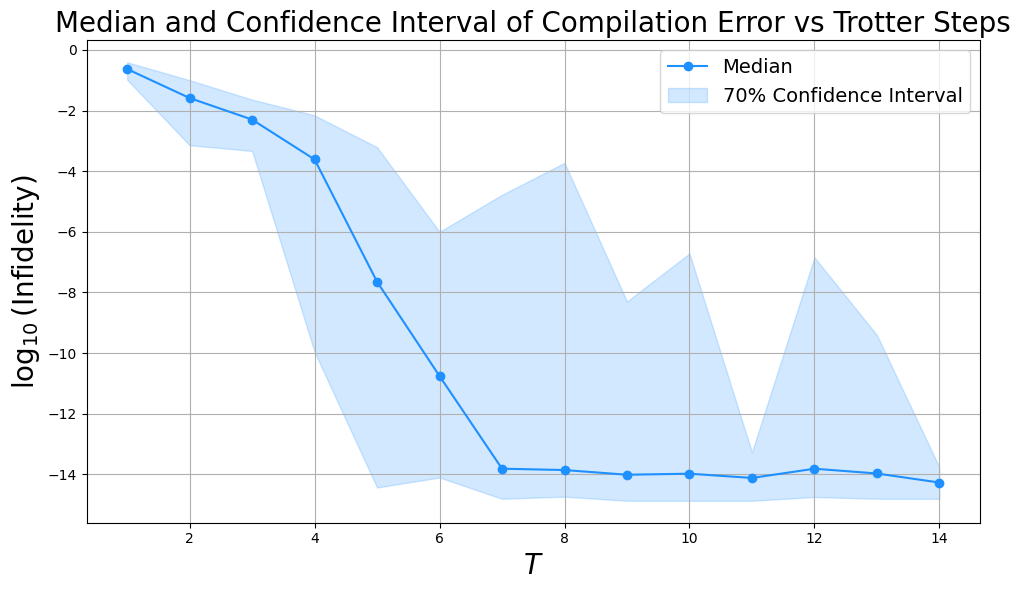

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


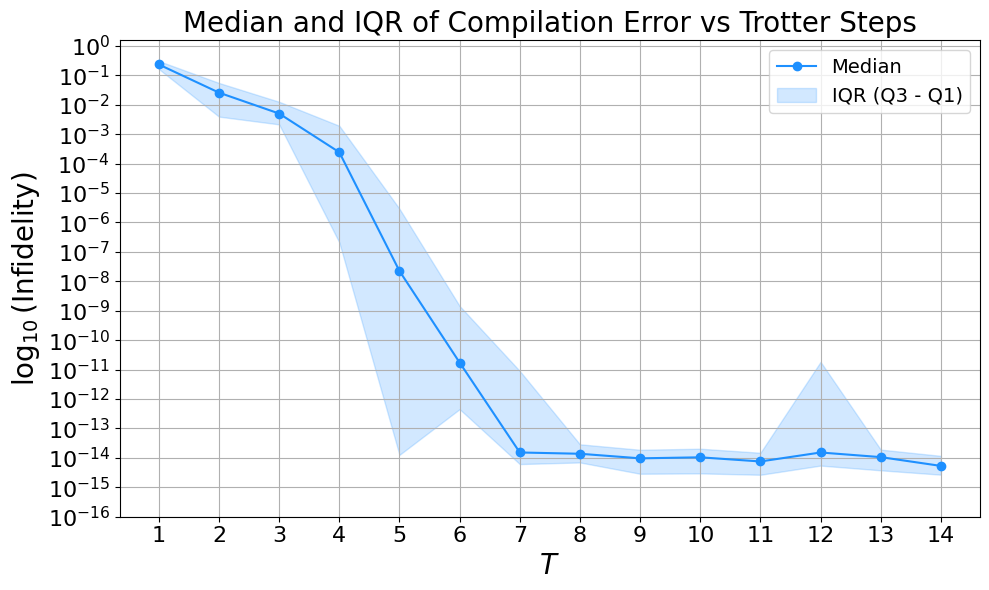

[1, 3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 28, 29]


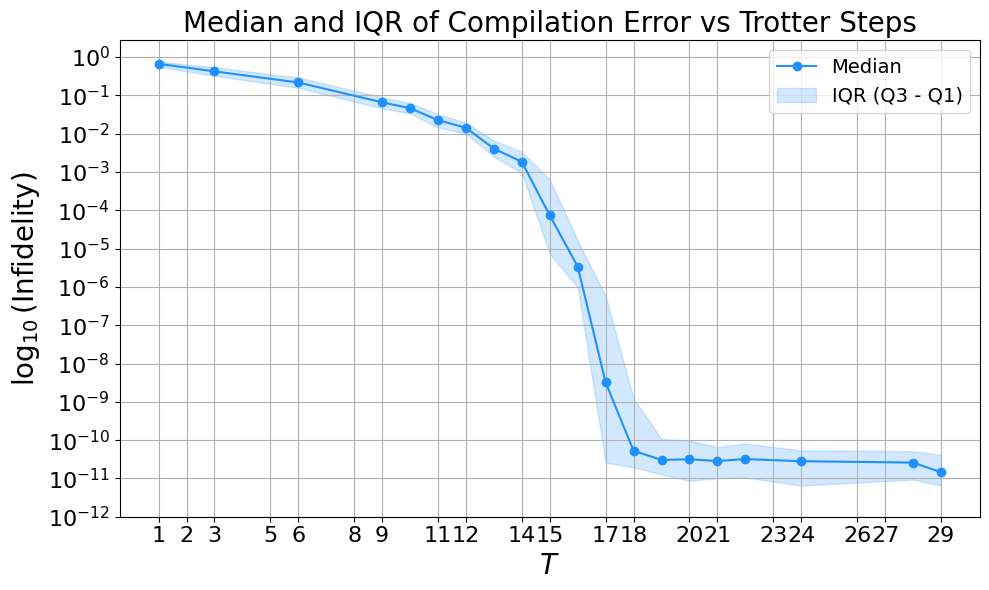

In [383]:

# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 30)  # 25th percentile
            q3 = np.percentile(exploded_values, 70)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to compute mean and standard deviation for each Trotter step
def compute_error_statistics_std(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            mean = np.mean(exploded_values)
            std = np.std(exploded_values)
            statistics[trotter_step] = (mean, std)
    return statistics
# Function to plot median with IQR as a shaded region and log scale applied after
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    print(trotter_steps)
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')
    # num_ticks = 10  # Adjust this for more or fewer ticks
    num_ticks = len(trotter_steps)
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

def plot_error_with_std(data_df, N_ctrl, N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl and Reservoir Count
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics_std(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    print(trotter_steps)
    means = [np.log10(mean) for mean, _ in statistics.values()]
    std_devs = [np.log10(mean + std) - np.log10(mean) for mean, std in statistics.values()]

    # Plot mean and standard deviation
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, means, label='Mean', marker='o', color='dodgerblue')
    axs.fill_between(
        trotter_steps,
        np.array(means) - np.array(std_devs),
        np.array(means) + np.array(std_devs),
        color='dodgerblue',
        alpha=0.2,
        label='Std Dev'
    )

    # Customize x-axis ticks
    num_ticks = len(trotter_steps)
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()
def plot_error_with_precomputed_log(data_df, N_ctrl, N_R, xlabel, ylabel, title, confidence=0.50):
    """
    Plot error statistics with precomputed log-transformed infidelities.
    Median and percentile-based confidence intervals are calculated directly in log scale.
    
    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'log_infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        confidence (float): Confidence level for the interval (default: 0.50).
    """
    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Ensure there are no NaNs in the 'log_infidelities' column
    if filtered_df['infidelities'].isna().any():
        raise ValueError("NaN values detected in the 'infidelities' column! Check the data preprocessing step.")

    # Explode the 'infidelities' and precompute log infidelities
    print("Exploding 'infidelities' column into individual rows and computing log infidelities...")
    exploded_df = filtered_df.explode('infidelities').reset_index()
    exploded_df['infidelities'] = pd.to_numeric(exploded_df['infidelities'], errors='coerce')
    exploded_df['log_infidelities'] = np.log10(exploded_df['infidelities'])

    # Percentiles for the confidence interval
    confidence_level = confidence
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100

    # Calculate median and confidence intervals in log scale
    print("Calculating median and confidence intervals in log scale...")
    stats = exploded_df.groupby('Trotter_Step')['log_infidelities'].agg(
        median=np.median,
        ci_lower=lambda x: np.percentile(x, lower_percentile),
        ci_upper=lambda x: np.percentile(x, upper_percentile)
    ).reset_index()

    # Print values for each Trotter step
    print("\nTrotter Step | Median (Log) | CI Lower (Log) | CI Upper (Log)")
    for i, row in stats.iterrows():
        print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, Q1: {row['ci_lower']}, Q3: {row['ci_upper']}")

        print(f"{row['Trotter_Step']:>12} | {row['median']:<10.6f} | {row['ci_lower']:<10.6f} | {row['ci_upper']:<10.6f}")

    # Plotting
    print("Plotting the data...")
    plt.figure(figsize=(10, 6))

    # Plot the median line with markers
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the shaded region for confidence intervals
    plt.fill_between(
        stats['Trotter_Step'],
        stats['ci_lower'],
        stats['ci_upper'],
        color='dodgerblue',
        alpha=0.2,
        label=f'{int(confidence_level * 100)}% Confidence Interval'
    )

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    plt.show()
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'Reservoir Count', 'N_C'])
    .agg({
        'infidelities': lambda x: sum(x, []),  # Combine lists of infidelities
        'Error_Test_Results': lambda x: sum(x, []),  # Combine test results
    })
    .reset_index()
)

plot_error_with_precomputed_log(
    data_df=aggregated_data,
    N_ctrl=1,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and Confidence Interval of Compilation Error vs Trotter Steps',
    confidence=0.70  # 50% confidence interval
)
# # Example Usage:
# plot_error_with_std(
#     data_df=aggregated_data,
#     N_ctrl=1,
#     N_R=1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Mean and Standard Deviation of Compilation Error vs Trotter Steps'
# )


# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=aggregated_data,
    N_ctrl=1,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)
plot_error_with_iqr(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)
# aggregated_data = (
#     all_data_df
#     .groupby(['Trotter_Step', 'Reservoir Count', 'N_C', 'N_params'])
#     .agg({
#         'infidelities': lambda x: sum(x, []),  # Combine lists of infidelities
#         'Error_Test_Results': lambda x: sum(x, []),  # Combine test results
#         'Mean': 'count'  # Optionally count the number of gates per group
#     })
#     .reset_index()  # Flatten the grouped DataFrame
# )

# plot_error_with_iqr(
#     data_df=all_data_df,
#     N_ctrl=2,
#     N_R = 1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Median and IQR of Compilation Error vs Trotter Steps'
# )


Calculating median and IQR...

Trotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)
Trotter Step: 1.0, Median: -0.631397922406209, Q1: -1.1969111719749783, Q3: -0.3023942819733737
Trotter Step: 2.0, Median: -1.588327306581296, Q1: -3.7244852189020516, Q3: -0.707353166474418
Trotter Step: 3.0, Median: -2.2990074833556013, Q1: -3.6605331212729317, Q3: -1.3714956477095572
Trotter Step: 4.0, Median: -3.6140624074830505, Q1: -14.811789285043844, Q3: -1.1969005957109708
Trotter Step: 5.0, Median: -7.649433152023176, Q1: -15.699146850250777, Q3: -1.4194516378426902
Trotter Step: 6.0, Median: -10.863190954082905, Q1: -15.689088919764634, Q3: -3.682080971763276
Trotter Step: 7.0, Median: -15.05149978319906, Q1: -15.708855049942049, Q3: -3.515057178705945
Trotter Step: 8.0, Median: -15.658803764238659, Q1: -15.734770162038975, Q3: -2.9205377415082836
Trotter Step: 9.0, Median: -15.659296266967191, Q1: -15.72427300559453, Q3: -5.554899151598877
Trotter Step: 10.0, Median: -15.6587011054684

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/2764866251.py:214: FutureWarning: The provided callable <function median at 0x116984540> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats = exploded_df.groupby('Trotter_Step')['Error_Test_Results'].agg(


Displaying plot...


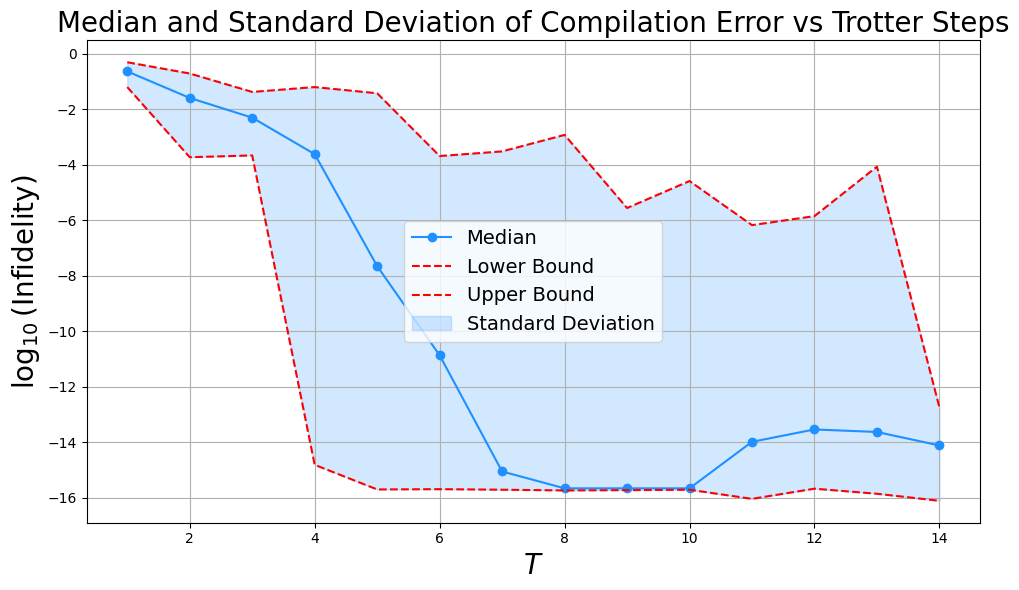

Calculating median and IQR...

Trotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)
Trotter Step: 1.0, Median: -0.17688454449047103, Q1: -0.48205981853738283, Q3: -0.03547616186305927
Trotter Step: 3.0, Median: -0.3730250337647212, Q1: -0.7789887598382157, Q3: -0.09922709010245592
Trotter Step: 6.0, Median: -0.6637291089205513, Q1: -1.0657656983623216, Q3: -0.2912259110532663
Trotter Step: 9.0, Median: -1.1815863830456006, Q1: -1.7469937032584173, Q3: -0.8039367006687598
Trotter Step: 10.0, Median: -1.33555851983298, Q1: -1.99188054026576, Q3: -0.9536323286085303
Trotter Step: 11.0, Median: -1.6471738707575359, Q1: -2.2930963722177293, Q3: -1.1928053907191407
Trotter Step: 12.0, Median: -1.8461179184895362, Q1: -2.3251069759219125, Q3: -1.3923354836332147
Trotter Step: 13.0, Median: -2.3887397268797725, Q1: -3.07502749420816, Q3: -1.8050497405618062
Trotter Step: 14.0, Median: -2.734936750932235, Q1: -3.9403759527779987, Q3: -1.9652759781358469
Trotter Step: 15.0, Median: -4.135

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_19912/2764866251.py:214: FutureWarning: The provided callable <function median at 0x116984540> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats = exploded_df.groupby('Trotter_Step')['Error_Test_Results'].agg(


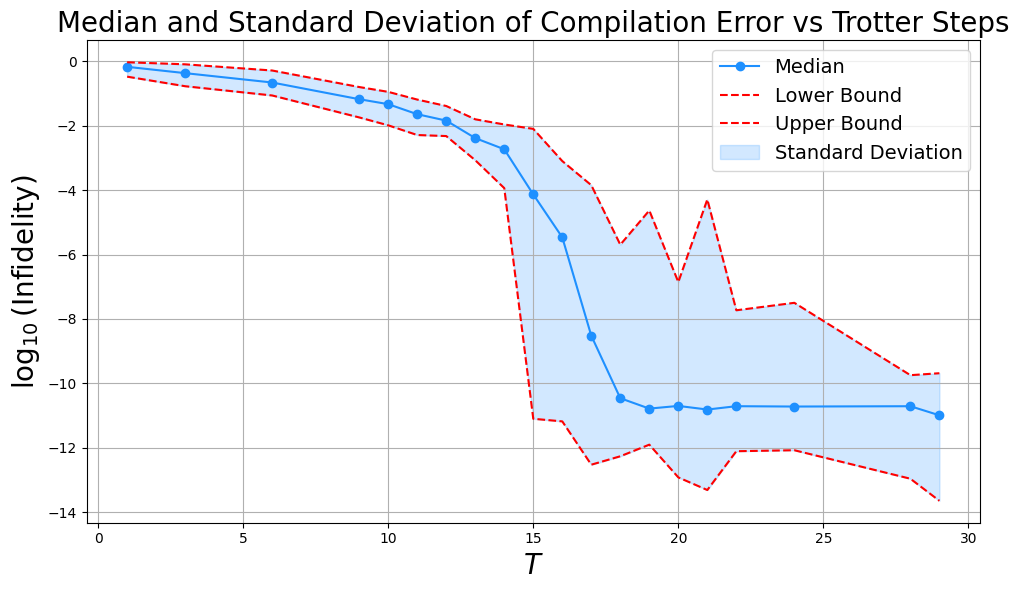

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t

def plot_error_with_seaborn_infidelities(data_df, N_ctrl, N_R, xlabel, ylabel, title, confidence=0.50):
    """
    Plot error statistics using Seaborn and manual precomputation of median and confidence intervals for log scale.
    
    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        confidence (float): Confidence level for the interval (default: 0.50).
    """
    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Ensure there are no NaNs in the 'infidelities' column
    if filtered_df['infidelities'].isna().any():
        raise ValueError("NaN values detected in the 'infidelities' column! Check the data preprocessing step.")

    # Explode the 'infidelities' column so each value is in its own row
    print("Exploding 'infidelities' column into individual rows...")
    exploded_df = filtered_df.explode('infidelities').reset_index()
    

    # Ensure that the exploded 'infidelities' column contains only numeric data
    exploded_df['infidelities'] = pd.to_numeric(exploded_df['infidelities'], errors='coerce')

    # Calculate median and confidence intervals for each Trotter step
    print("Calculating median and confidence intervals...")
    stats = exploded_df.groupby('Trotter_Step')['infidelities'].agg(
        median=np.median,
        ci_lower=lambda x: (np.median(x) - t.ppf((1 + confidence) / 2, len(x) - 1) * sem(x)) - 1e-10,
        ci_upper=lambda x: (np.median(x) + t.ppf((1 + confidence) / 2, len(x) - 1) * sem(x))+ 1e-10
    ).reset_index()

    # Print median and confidence interval values for each Trotter step

    print("\nTrotter Step | Median | CI Lower | CI Upper")
    for _, row in stats.iterrows():
        print(f"{row['Trotter_Step']:>12} | {row['median']:<10.6f} | {row['ci_lower']:<10.6f} | {row['ci_upper']:<10.6f}")
    # Print median and confidence interval values for each Trotter step
    # print("\nTrotter Step | Median | CI Lower | CI Upper")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, CI Lower: {row['ci_lower']}, CI Upper: {row['ci_upper']}")

  

    plt.figure(figsize=(10, 6))

    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the shaded region (Confidence Interval)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['ci_lower'],
        stats['ci_upper'],
        color='dodgerblue',
        alpha=0.2,
        label=f'{int(confidence*100)}% Confidence Interval'
    )


    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()
# Aggregate the data first
trots = 1,2,3
def plot_error_with_seaborn(data_df, N_ctrl, N_R, xlabel, ylabel, title, confidence=0.50):
    """
    Plot error statistics using Seaborn and manual precomputation of median and confidence intervals for log scale.
    
    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        confidence (float): Confidence level for the interval (default: 0.50).
    """
    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]
    # filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R) & (data_df['Trotter_Step'] <4)]
    # Ensure there are no NaNs in the 'infidelities' column
    if filtered_df['Error_Test_Results'].isna().any():
        raise ValueError("NaN values detected in the 'infidelities' column! Check the data preprocessing step.")

    # Explode the 'infidelities' column so each value is in its own row
    print("Exploding 'infidelities' column into individual rows...")
    exploded_df = filtered_df.explode('Error_Test_Results').reset_index()
    

    # Ensure that the exploded 'infidelities' column contains only numeric data
    exploded_df['Error_Test_Results'] = pd.to_numeric(exploded_df['Error_Test_Results'], errors='coerce')
    scale = 1
    # Calculate median and confidence intervals for each Trotter step
    print("Calculating median and confidence intervals...")
    stats = exploded_df.groupby('Trotter_Step')['Error_Test_Results'].agg(
        median=np.median,
        ci_lower=lambda x: (np.median(x) - t.std((1 + confidence) / 2, len(x) - 1,scale=scale) * sem(x,ddof=0)) - 1e-9,
        ci_upper=lambda x: (np.median(x) + t.std((1 + confidence) / 2, len(x) - 1,scale=scale) * sem(x,ddof=0))+ 1e-9
    ).reset_index()
    # debug_data = stats[(stats['Trotter_Step'] > 17) & all_data_df['Reservoir Count'] == 1]
    print(stats[['Trotter_Step', 'median','ci_lower', 'ci_upper']])

    # Print median and confidence interval values for each Trotter step

    print("\nTrotter Step | Median | CI Lower | CI Upper")
    for _, row in stats.iterrows():
        print(f"{row['Trotter_Step']:>12} | {row['median']:3e} | {row['ci_lower']:3e} | {row['ci_upper']:3e}")
    # Print median and confidence interval values for each Trotter step
    # print("\nTrotter Step | Median | CI Lower | CI Upper")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, CI Lower: {row['ci_lower']}, CI Upper: {row['ci_upper']}")

  

    plt.figure(figsize=(10, 6))

    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )
    # plt.plot(
    #     stats['Trotter_Step'], stats['ci_lower'], 
    #     label='Lower Bound', 
    #     linestyle='--', 
    #     color='red'
    # )

    # # Plot the upper bound as a red line
    # plt.plot(
    #     stats['Trotter_Step'], stats['ci_upper'], 
    #     label='Upper Bound', 
    #     linestyle='--', 
    #     color='red'
    # )

    # Plot the shaded region (Confidence Interval)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['ci_lower'],
        stats['ci_upper'],
        color='dodgerblue',
        alpha=0.2,
        label=f'{int(confidence*100)}% Confidence Interval'
    )
    

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()

def plot_error_with_std(data_df, N_ctrl, N_R, xlabel, ylabel, title):
    """
    Plot error statistics using the median and standard deviation for log scale.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Error_Test_Results', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """
    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    # print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Ensure there are no NaNs in the 'Error_Test_Results' column
    if filtered_df['Error_Test_Results'].isna().any():
        raise ValueError("NaN values detected in the 'Error_Test_Results' column! Check the data preprocessing step.")

    # Explode the 'Error_Test_Results' column into individual rows
    # print("Exploding 'Error_Test_Results' column into individual rows...")
    exploded_df = filtered_df.explode('Error_Test_Results').reset_index()

    # Ensure that the exploded column contains only numeric data
    exploded_df['Error_Test_Results'] = pd.to_numeric(exploded_df['Error_Test_Results'], errors='coerce')

   # Calculate median and IQR for each Trotter step
    print("Calculating median and IQR...")
    stats = exploded_df.groupby('Trotter_Step')['Error_Test_Results'].agg(
        median=np.median,
        q1=lambda x: np.percentile(x, 5),  # 25th percentile
        q3=lambda x: np.percentile(x, 95)   # 75th percentile
    ).reset_index()

    # Compute the bounds
    stats['lower_bound'] = stats['q1']  # Lower bound = Q1 (25th percentile)
    stats['upper_bound'] = stats['q3']  # Upper bound = Q3 (75th percentile)

    # Print the statistics
    print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    for _, row in stats.iterrows():
        print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, Q1: {row['lower_bound']}, Q3: {row['upper_bound']}")

    # Plotting
    plt.figure(figsize=(10, 6))
    # Plot the median line
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the lower bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['lower_bound'], 
        label='Lower Bound', 
        linestyle='--', 
        color='red'
    )

    # Plot the upper bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['upper_bound'], 
        label='Upper Bound', 
        linestyle='--', 
        color='red'
    )

    # Plot the shaded region (Standard Deviation)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['lower_bound'],
        stats['upper_bound'],
        color='dodgerblue',
        alpha=0.2,
        label='Standard Deviation'
    )

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()
# Aggregate the data first

aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'Reservoir Count', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: sum(x, []),  # Combine lists of infidelities
        'Error_Test_Results': lambda x: sum(x, []),  # Combine test results
    })
    .reset_index()
)
plot_error_with_std(
    data_df=aggregated_data,
    N_ctrl=1,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and Standard Deviation of Compilation Error vs Trotter Steps'
)

plot_error_with_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and Standard Deviation of Compilation Error vs Trotter Steps'
)
# Plot for N_ctrl=1 and Reservoir Count=1
# plot_error_with_seaborn(
#     data_df=aggregated_data,
#     N_ctrl=1,
#     N_R=1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Median and 50% Confidence Interval of Compilation Error vs Trotter Steps',
#     confidence=0.99  # 50% confidence interval
# )

# # Plot for N_ctrl=1 and Reservoir Count=1
# plot_error_with_seaborn_infidelities(
#     data_df=aggregated_data,
#     N_ctrl=1,
#     N_R=1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Median and 50% Confidence Interval of Compilation Error vs Trotter Steps',
#     confidence=0.9  # 50% confidence interval
# )



Filtering data for N_ctrl=1 and N_R=1...
Exploding 'Error Test Results' column into individual rows...
Calculating median and percentile intervals...

Trotter Step | Median | Percentile Lower | Percentile Upper
         1.0 | -0.631398  | -0.840832  | -0.483245 
         2.0 | -1.588327  | -2.528310  | -1.173076 
         3.0 | -2.299007  | -2.811426  | -1.827202 
         4.0 | -3.614062  | -7.311217  | -2.557546 
         5.0 | -7.649433  | -15.653560 | -4.203813 
         6.0 | -10.677134 | -14.176439 | -7.827173 
         7.0 | -15.051500 | -15.653560 | -10.099358
         8.0 | -15.653560 | -15.653560 | -8.000000 
         9.0 | -15.653560 | -15.653560 | -12.158432
        10.0 | -15.653560 | -15.653560 | -9.787058 
Displaying plot...


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_70377/4210724590.py:35: FutureWarning: The provided callable <function median at 0x104578540> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats = exploded_df.groupby('Trotter_Step')['Error Test Results'].agg(


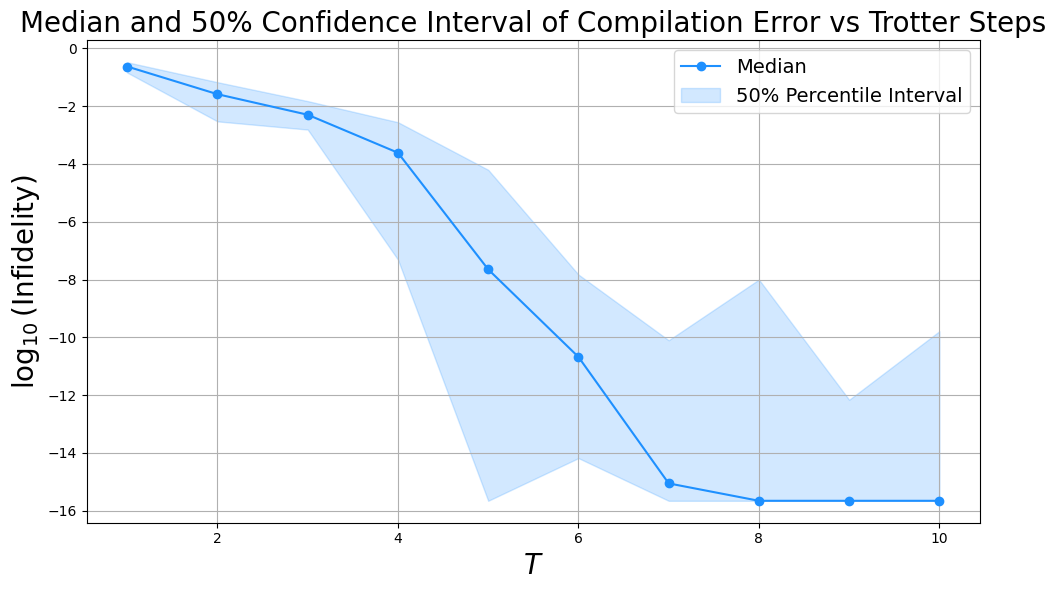

In [222]:
def plot_error_with_percentiles(data_df, N_ctrl, N_R, xlabel, ylabel, title, confidence=0.50):
    """
    Plot error statistics using percentile intervals for log scale.
    
    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        confidence (float): Percentile interval width (default: 0.50).
    """
    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Ensure there are no NaNs in the 'Error_Test_Results' column
    if filtered_df['Error_Test_Results'].isna().any():
        raise ValueError("NaN values detected in the 'Error_Test_Results' column! Check the data preprocessing step.")

    # Explode the 'Error_Test_Results' column into individual rows
    print("Exploding 'Error_Test_Results' column into individual rows...")
    exploded_df = filtered_df.explode('Error_Test_Results').reset_index()

    # Ensure that the exploded column contains only numeric data
    exploded_df['Error_Test_Results'] = pd.to_numeric(exploded_df['Error_Test_Results'], errors='coerce')

    # Define lower and upper percentiles
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100

    # Calculate median and percentiles for each Trotter step
    print("Calculating median and percentile intervals...")
    stats = exploded_df.groupby('Trotter_Step')['Error_Test_Results'].agg(
        median=np.median,
        ci_lower=lambda x: np.percentile(x, lower_percentile) if len(x) > 1 else x.iloc[0],
        ci_upper=lambda x: np.percentile(x, upper_percentile) if len(x) > 1 else x.iloc[0]
    ).reset_index()

    # Debugging Output: Print values for each Trotter step
    print("\nTrotter Step | Median | Percentile Lower | Percentile Upper")
    for _, row in stats.iterrows():
        print(f"{row['Trotter_Step']:>12} | {row['median']:<10.6f} | {row['ci_lower']:<10.6f} | {row['ci_upper']:<10.6f}")

    # Ensure no bounds collapse (i.e., ci_lower == median or ci_upper == median)
    stats['ci_lower'] = stats['ci_lower'].where(stats['ci_lower'] < stats['median'], stats['median'])
    stats['ci_upper'] = stats['ci_upper'].where(stats['ci_upper'] > stats['median'], stats['median'])

    plt.figure(figsize=(10, 6))

    # Plot the median line
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the shaded region (Percentile Interval)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['ci_lower'],
        stats['ci_upper'],
        color='dodgerblue',
        alpha=0.2,
        label=f'{int(confidence*100)}% Percentile Interval'
    )

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()



# Plot for N_ctrl=1 and Reservoir Count=1
plot_error_with_percentiles(
    data_df=aggregated_data,
    N_ctrl=1,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and 50% Confidence Interval of Compilation Error vs Trotter Steps',
    confidence=0.50  # 50% confidence interval
)

Filtering data for N_ctrl=1 and N_R=1...
Exploding 'infidelities' column into individual rows...


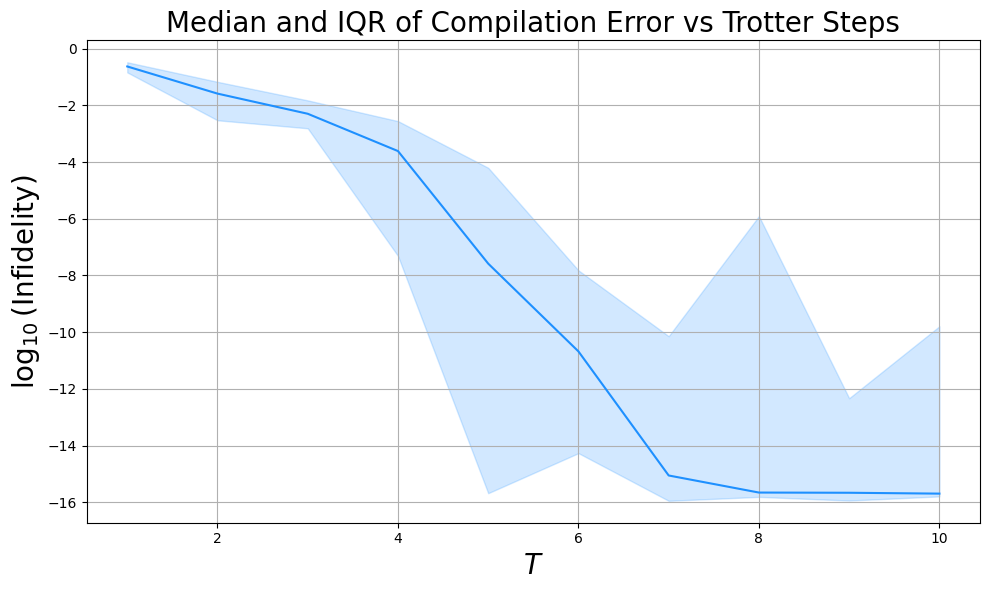

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_with_seaborn(data_df, N_ctrl, N_R, xlabel, ylabel, title):
    """
    Plot error statistics using Seaborn.
    The central tendency is the median, and the spread is represented by a confidence interval (CI).
    
    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """
    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Ensure there are no NaNs in the 'infidelities' column
    if filtered_df['infidelities'].isna().any():
        raise ValueError("NaN values detected in the 'infidelities' column! Check the data preprocessing step.")

    # Explode the 'infidelities' column so each value is in its own row
    print("Exploding 'infidelities' column into individual rows...")
    exploded_df = filtered_df.explode('Error_Test_Results').reset_index()

    # Ensure that the exploded 'infidelities' column contains only numeric data
    exploded_df['infidelities'] = pd.to_numeric(exploded_df['Error_Test_Results'], errors='coerce')

 
    plt.figure(figsize=(10, 6))

    # Plot using Seaborn's lineplot with estimator as median
    sns.lineplot(
        data=exploded_df,
        x='Trotter_Step',
        y='Error_Test_Results',
        estimator='median',  # Use median as the central tendency
        errorbar=('pi',50),       # Use percentile interval (IQR for shaded region)
        markers=True,
        dashes=False,
        color='dodgerblue'
    )
    # plt.yscale('log')
        # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
  
    plt.show()
# Aggregate the data first
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'Reservoir Count', 'N_C'])
    .agg({
        'infidelities': lambda x: sum(x, []),  # Combine lists of infidelities
        'Error_Test_Results': lambda x: sum(x, []),  # Combine test results
    })
    .reset_index()
)

# Plot for N_ctrl=1 and Reservoir Count=1
plot_error_with_seaborn(
    data_df=aggregated_data,
    N_ctrl=1,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)

In [92]:
debug_data = all_data_df[(all_data_df['Trotter_Step'] > 17) & all_data_df['Reservoir Count'] == 1]
print(debug_data[['Gate','Trotter_Step', 'infidelities', 'Error_Test_Results']])

      Gate  Trotter_Step                                       infidelities  \
612   U2_0            20  [1e-10, 1e-10, 4.8824260190372115e-09, 1e-10, ...   
613   U2_0            21  [1e-10, 1e-10, 1e-10, 1.3604157800273242e-09, ...   
614   U2_0            28  [1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-...   
615   U2_0            29  [1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-...   
616   U2_0            18  [1e-10, 1e-10, 1e-10, 1e-10, 1.999913346040216...   
...    ...           ...                                                ...   
1732  U2_9            29  [0.004746029391077822, 0.011395989002860207, 0...   
1733  U2_9            18  [0.07579666678914043, 0.06917849713815871, 0.0...   
1734  U2_9            19  [0.09812361396806557, 0.08583444496541348, 0.0...   
1735  U2_9            22  [0.02876474714100996, 0.023852018078698856, 0....   
1736  U2_9            24  [0.06291050267305132, 0.0625811608011081, 0.04...   

                                     Error Test Res

In [110]:
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'Reservoir Count', 'N_C'])
    .agg({
        'infidelities': lambda x: sum(x, []),  # Combine lists of infidelities
        'Error_Test_Results': lambda x: sum(x, []),  # Combine test results
     
    })
    .reset_index()  # Flatten the grouped DataFrame
)
print(aggregated_data.head())

   Trotter_Step  Reservoir Count  N_C  \
0             1                1    1   
1             1                1    2   
2             1                2    1   
3             1                2    2   
4             1                3    1   

                                        infidelities  \
0  [0.24264315460766828, 0.23395788232216963, 0.3...   
1  [0.9438095867606008, 0.8368229406569978, 0.372...   
2  [0.36426192667913426, 0.2505137888924951, 0.49...   
3  [0.4556805545518031, 0.8379444485680038, 0.724...   
4  [0.2515264965427201, 0.2148090096608516, 0.335...   

                                  Error Test Results  
0  [-0.6150319563909431, -0.6308623183223865, -0....  
1  [-0.025115615617690323, -0.0773664225683625, -...  
2  [-0.4385862196372099, -0.6011683645068754, -0....  
3  [-0.34133950385344564, -0.07678477191872676, -...  
4  [-0.5994162583370201, -0.6679475071254944, -0....  


In [90]:
filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == 1)]
    

filtered_df['infidelities'] = pd.to_numeric(filtered_df['infidelities'], errors='coerce')
print(filtered_df[['Gate','Trotter_Step', 'infidelities']])

       Gate  Trotter_Step  infidelities
600    U2_0             1           NaN
602    U2_0             6           NaN
604    U2_0            10           NaN
606    U2_0            12           NaN
607    U2_0            13           NaN
...     ...           ...           ...
1694   U2_9            19           NaN
1695   U2_9            22           NaN
1696   U2_9            24           NaN
1737  U2_19             1           NaN
1739  U2_19             6           NaN

[287 rows x 3 columns]


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_70377/1988154817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['infidelities'] = pd.to_numeric(filtered_df['infidelities'], errors='coerce')
